# SMS Spam Detection

## Dataset
For this project, I will be utilizing the [SMS Spam Collection Dataset
](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset). 

This dataset consists of 5572 SMS (Short Message Service) messages that are labeled as either "spam" or "ham" (not spam).


## Problem Description
The goal of this project is to use several unsupervised learning techniques for dimensionality reduction for detecting spam messages, as well as evaluate how well each approach performs in terms of extracting latent structures and interpretability.

In particular, I will represent the text data as a Bag-of-Words (BoW) model using scikit-learn's CountVectorizer, which I will reduce the dimensionality using three unsupervised learning techniques: TruncatedSVD, Non-Negative Matrix Factorization (NMF), and Uniform Manifold Approximation and Projection (UMAP). For each approach, I will train and evaluate a Logistic Regression classifier as well as use K-Means for clustering.

# Data Preprocessing and Exploratory Data Analysis

Before converting the data with CountVectorizer, I will clean and preprocessing the data. I used spaCy to help with the preprocessing step. I then split the data into training and test sets before perform EDA on the training set.

In [1]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='latin-1')

data.head()

v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN

In [4]:
# Rename the first two columns, and remove the other columns
data = data[['v1', 'v2']]
data.rename(columns={'v1': 'Label', 'v2': 'Text'}, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   Text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
# Check for empty strings
print("Empty text in data:", (data['Text'] == "").any())

# Find number of duplicate text
dupes = data[data.duplicated(subset='Text', keep=False)]
print("Number of duplicate HAM to remove:", data[data['Label'] == 'ham']['Text'].duplicated().sum())
print("Number of duplicate SPAM to remove:", data[data['Label'] == 'spam']['Text'].duplicated().sum())

Empty text in data: False
Number of duplicate HAM to remove: 309
Number of duplicate SPAM to remove: 94


In [6]:
# Remove duplicate comments while keeping the first instance
print("Number of rows before removing dupes:", data.shape[0])
data = data.drop_duplicates(subset='Text', keep='first')
print("Number of rows after removing dupes:", data.shape[0])

Number of rows before removing dupes: 5572
Number of rows after removing dupes: 5169


## Check for null values, empty strings, and duplicate strings

There are three unnecessary columns, so I just kept the first two and renamed the columns appropriately. There aren't any null values or empty strings for these two columns.

There are a few hundred duplicate texts so I kept only the first instances while removing extras.

In [7]:
# Print the first five instances of each label
for label in ['ham', 'spam']:
    for i in range(5):
        text = data[data['Label'] == label]['Text'].iloc[i]
        print(f"{label} {i + 1}: {text}\n")

ham 1: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

ham 2: Ok lar... Joking wif u oni...

ham 3: U dun say so early hor... U c already then say...

ham 4: Nah I don't think he goes to usf, he lives around here though

ham 5: Even my brother is not like to speak with me. They treat me like aids patent.

spam 1: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

spam 2: FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv

spam 3: WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.

spam 4: Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Upda

In [8]:
import spacy
import re
from tqdm import tqdm

nlp = spacy.load("en_core_web_sm")

# Returns token list
def process_text(data):
    tokens_list = []
    docs = tqdm(nlp.pipe(data, batch_size=512, n_process=-1), total=len(data), desc="Processing texts")
    for doc in docs:
        # Lemmatize and lowercase words and exclude stop words, number words, and spaces
        tokens = [
            token.lemma_.lower() for token in doc
            if not token.is_stop
            and not token.like_num
            and not token.is_space
        ]
        # Remove digits from each token
        tokens = [re.sub(r'\d+', '', token) for token in tokens]
        tokens_list.append(' '.join(tokens))
    return tokens_list

# Tokenize the text
data['ProcessedText'] = process_text(data['Text'])

# Get Length (token count) of each processed text
data['Length'] = data['ProcessedText'].str.split().str.len()

data.head()

Processing texts: 100%|██████████| 5169/5169 [00:14<00:00, 355.27it/s]


Label                                               Text  \
0   ham  Go until jurong point, crazy.. Available only ...   
1   ham                      Ok lar... Joking wif u oni...   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...   
3   ham  U dun say so early hor... U c already then say...   
4   ham  Nah I don't think he goes to usf, he lives aro...   

                                       ProcessedText  Length  
0  jurong point , crazy .. available bugis n grea...      19  
1                      ok lar ... joke wif u oni ...       8  
2  free entry wkly comp win fa cup final tkts . t...      19  
3                        u dun early hor ... u c ...       8  
4                            nah think go usf , live       6

## Data Preprocessing

Looking at the example texts, it seems that punctuation may be important so we will keep them as tokens. Numbers could be useful depending on the context, but with our bag-of-words representation of the data, it may just contribute as noise so I removed any digits and number words. I also removed stop words, as well as lower-cased and lemmatized the words.

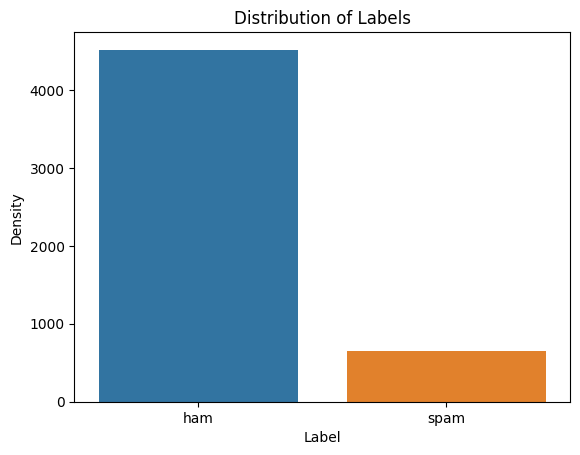

In [9]:
# Plot distribution of each label
sns.barplot(x=data['Label'].value_counts().index, y=data['Label'].value_counts())
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Density')
plt.show()

## Imbalance of target variable

We see that there are about 6 times as many Ham messages compared to Spam messages. We will need to keep this in mind in the model building step.

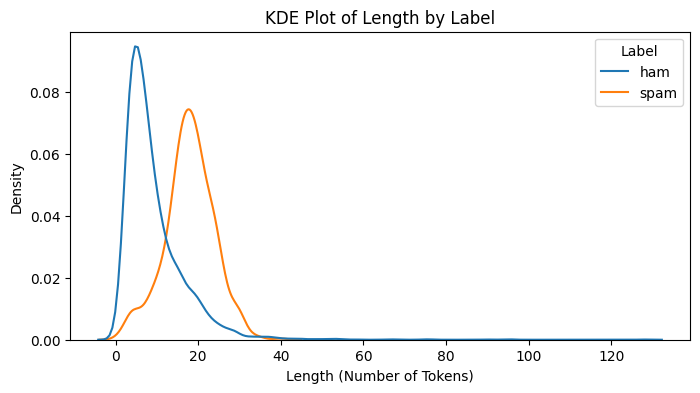

In [10]:
import warnings

# Ignore Future Warning for KDE plot
warnings.filterwarnings("ignore", category=FutureWarning)

# Plot KDF plot of Length (Number of Tokens) by Label
plt.figure(figsize=(8, 4))

sns.kdeplot(data=data, x='Length', hue='Label', common_norm=False)
plt.title('KDE Plot of Length by Label')
plt.xlabel('Length (Number of Tokens)')
plt.ylabel('Density')

plt.show()

warnings.filterwarnings("default", category=FutureWarning)

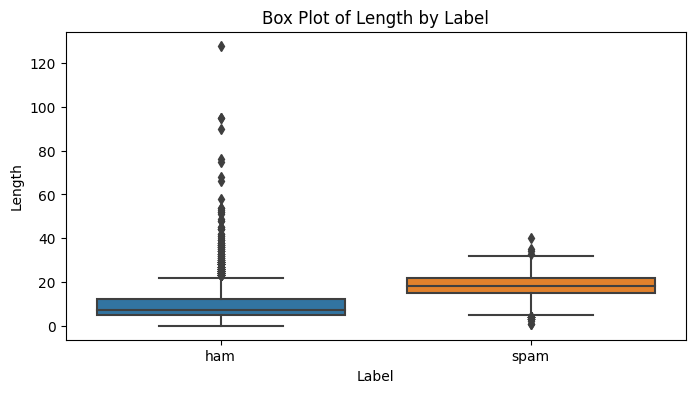

In [11]:
plt.figure(figsize=(8, 4))

# 'Boxlot of Word Count grouped by Emotion'
sns.boxplot(data=data, x='Label', y='Length')
plt.title('Box Plot of Length by Label')
plt.xlabel('Label')
plt.ylabel('Length')

plt.show()

In [12]:
print("Number of rows with Length = 0:", (data['Length'] == 0).sum())
print("Number of rows with Length > 60:", (data['Length'] > 60).sum())

Number of rows with Length = 0: 2
Number of rows with Length > 60: 8


## Analysis of Word Lengths

Spam message seem to, on average, have a higher (ProcessedText) word count compared to Ham messages. However, for this particular dataset, we have a number of Ham messages with many more words. The longest Spam message has about 40 words, while there are 8 Ham messages with more than 60 words. Especially due to the Ham class having much higher representation in the data, the long outliers may introduce bias. Therefore, it may be best to remove the long messages. I removed the messages with more than 60 words

It also seems that after tokenization, two of the instances were left with 0 words so I removed them as well.

In [13]:
# Keep rows with Length > 0 and <= 60
orig_row_count = data.shape[0]
data = data[(data['Length'] > 0) & (data['Length'] <= 60)]
print(f"{orig_row_count - data.shape[0]} rows removed.")

10 rows removed.


## Splitting the data into training and test sets

I will use the 'ProcessedText' column as the text data to be used for the following steps. For the target labels, I will encode the labels as True for 'Spam' and False for 'Ham'.

Because the data is imbalanced, I will split the data by stratifying on the target variable. In other words, I will ensure that the ratio of Ham to Spam messages is roughly the same for both training and test sets.

In [14]:
from sklearn.model_selection import train_test_split

X = data['ProcessedText']
y = data['Label'] == 'spam' # Encode 'spam' as True and 'ham' as False

# Split into new training and test sets, stratifying on the target labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

print("Train proportions:", y_train.value_counts(normalize=True).values)
print("Test proportions: ",y_test.value_counts(normalize=True).values)

Train proportions: [0.87351587 0.12648413]
Test proportions:  [0.87306202 0.12693798]


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


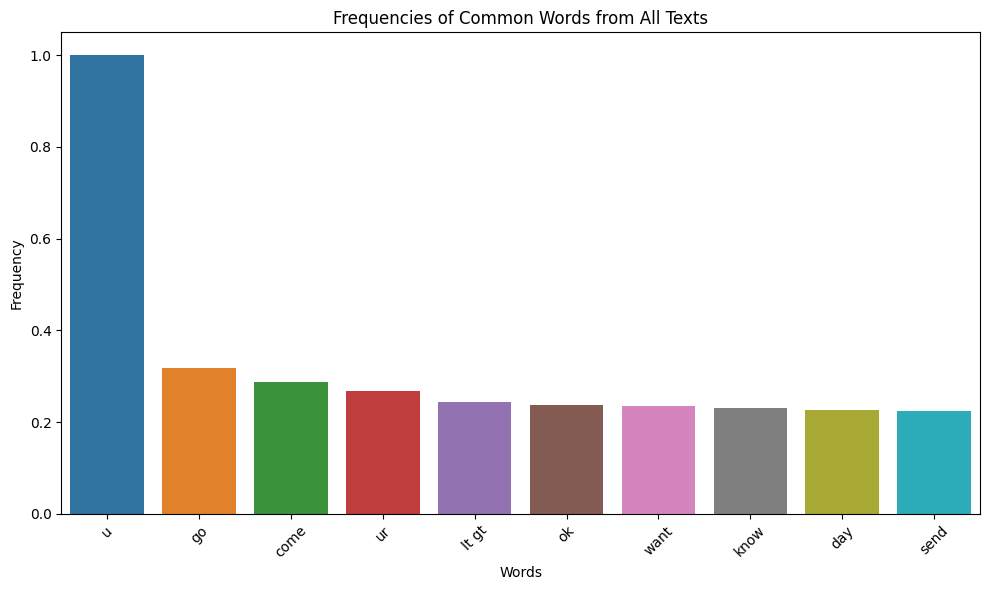

In [15]:
from wordcloud import WordCloud

words = []
freqs = []

# Get 10 most common words
texts = " ".join(X_train)
wordcloud = WordCloud(background_color='white').generate(texts)
common_words = sorted(wordcloud.words_.items(), key=lambda x: x[1], reverse=True)[:10]
for word, freq in common_words:
    words.append(word)
    freqs.append(freq)

plt.figure(figsize=(10, 6))
sns.barplot(x=words, y=freqs)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequencies of Common Words from All Texts')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

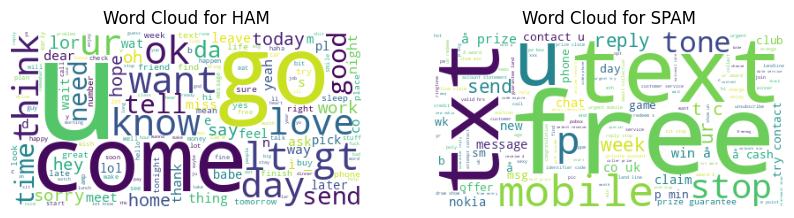

In [16]:
plt.figure(figsize=(10, 12))

# Display word clouds for HAM
texts = " ".join(X_train[y_train == 0])
wordcloud = WordCloud(background_color='white').generate(texts)
plt.subplot(1, 2, 1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title(f'Word Cloud for HAM')

# Display word clouds for SPAM
texts = " ".join(X_train[y_train == 1])
wordcloud = WordCloud(background_color='white').generate(texts)
plt.subplot(1, 2, 2)
plt.imshow(wordcloud)
plt.axis('off')
plt.title(f'Word Cloud for SPAM')
    
plt.show()

In [17]:
# Get first 10 texts from X_train that contain 'lt' or 'gt'
X_train[X_train.str.contains(r'\b(lt|gt)\b')].head(10)

<ipython-input-17-ed7bc395d21b>:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X_train[X_train.str.contains(r'\b(lt|gt)\b')].head(10)


874     talk atleast day ... ! ! ! miss good friend wo...
3541                                ìï come lt n pass lar
4090    hey doc pls want nice t shirt hubby nice fit o...
44      great ! hope like man endow . & lt;#&gt ; inch...
5132    work . time try add zero . saving . checking &...
5504                         wait . msg & lt;#&gt ; min .
3798    actually nvm , get hella cash , & lt;#&gt ; ish ?
200                                 send & lt;#&gt ; buck
2793    affidavit say & lt;#&gt ; e twiggs st , divisi...
199                            find , enc & lt;#&gt ; , ?
Name: ProcessedText, dtype: object

## Analysis of Word Frequencies

The words "u" and "ur" are quite common for both classes. I will remove "u" and "ur" since they likely won't help add much context and are abbreviations of stop words "you" and "your" respectively which were previously removed.

A number of common words such as "come" and "text" are clearly more frequent in one class compared to the other. In this case it may be better to keep these words.

Meanwhile, "send" is common in both but seems slightly more common with the Spam class. To avoid bias towards the Spam class, I will remove the word "send".

"\&lt;" and "\&gt;" are HTML-encoded texts for "<" and ">" respectively. In the data, we see the expression "\&lt;#\&gt;" which decodes to "<#>" (Word Cloud removes the punctuation, treating "lt" and "gt" as separate words). This is likely a placeholder for special symbols such as emojis. We see from the Word Clouds that these are comparitively much more common in Ham messages than Spam messages, so it would be a good idea to keep these words as is.

In [18]:
# Remove the words 'u' and 'ur' from texts
def process_row(row):
    words = row.split()
    words = [word for word in words if word not in ['u', 'ur', 'send']]
    return ' '.join(words)
    
X_train = X_train.apply(process_row)
X_test = X_test.apply(process_row)

# Check if any texts became empty
print("Number of empty strings in X_train:", (X_train.str.strip() == '').sum())
print("Number of empty strings in X_test:", (X_test.str.strip() == '').sum())

Number of empty strings in X_train: 0
Number of empty strings in X_test: 0


# Model Building

I will be using **CountVectorizer** to represent the text documents as a document x term matrix where each entry contains the number of times a term appears in a document. This matrix is a *sparse* representation since there will be many zero values. Because each unique term represents a feature, the matrix will be high-dimensional. Therefore, I would like to explore a few unsupervised learning approaches for reducing the dimensionality of the data.

I will be building four models for Spam/Ham classification using **Logistic Regression**. The first will be a baseline model that simply trains a logistic regression classifier on the matrix produced by CountVectorizer. The other three will also use logistic regression, but each will be trained on a feature set produced by a different dimensionality reduction technique. The three unsupervised learning approaches for dimensionality reduction that I will be using are **Truncated SVD**, **Non-Negative Matrix Factorization**, and **Uniform Manifold Approximation**. I will also use **K-means clustering** on each of these reduced feature sets.

### Evaluation Metrics

Since there is imbalance in the target variable, accuracy is not a good metric for evaluation. Therefore I will be using the precision, recall, and F1 scores (the harmonic mean of precision and recall) as well as the AUC scores for evaluating the performances of each model.

## Count Vectorizer and Logistic Regression (Baseline Model)

I will use GridSearchCV for tuning the hyperparameters of the models. I will use the F1 score as the metric for choosing the best estimator (it uses accuracy by default). In addition, just as with the train-test split, I will stratify the cross-validation folds using StratifiedKFold.

Count Vectorizer has a few hyperparameters to choose. In particular:
* *ngram_range*: An n-gram is a token consisting of n consecutive words. For instance, a 1-gram (unigram) is just a single word like "now" or "ok" while a 2-gram (bigram) is a pair of consecutive words such as "will call" or "your friend". This allows us to capture some amount of context. After grid search, I found that including bigrams gave better results than only including unigrams, but including trigrams didn't make much of a difference. As a result, I set ngram_range to (1, 2) to only include unigrams and bigrams.
* *max_df*: This parameter ignores terms that have a document frequency above a specified. During EDA, I saw that only the word "u" had a very high frequency and manually removed it along with a couple other words. Therefore, I won't set a value for max_df.
* *min_df*: Similar to max_df, this parameter ignores low frequency terms. This there are most definitely many words that appear in only one or two documents, these words would not be useful and may instead contribute as noise and would be better removed. At the very least, I would want to exclude words that only appear in one document, but I will perform grid search for other values of min_df.

For Logistic Regression, I set the *class_weight* parameter to 'balanced' to handle imbalance. While there are a number of hyperparameters to tune, for simplicity I just tuned the regularization parameter *C* as the focus of this project is more on the dimensionality reduction techniques.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import pairwise_distances, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import time
import itertools

# Stratified k-fold cross-validator used during cross-validation
cv = StratifiedKFold(n_splits=5)

Runtime: 12.95 seconds


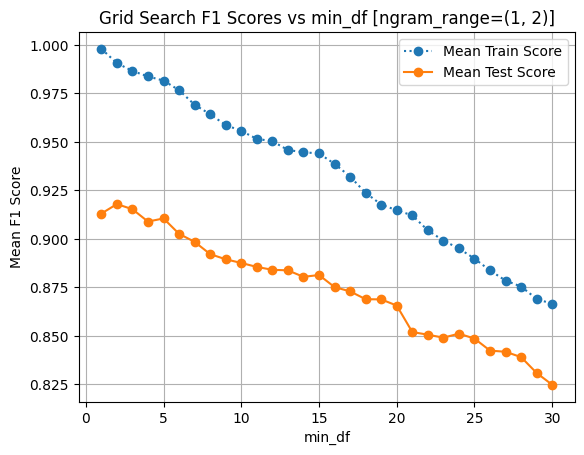

In [20]:
# CountVectorizer + LogReg Grid Search

ngram_range = (1, 2)
min_dfs = list(range(1, 31))

pipeline = Pipeline([
    ('cntvec', CountVectorizer(ngram_range=ngram_range)),
    ('logreg', LogisticRegression(max_iter=500, class_weight='balanced', random_state=2))
])

param_grid = {
    'cntvec__min_df': min_dfs
}

start_time = time.time()

gridsearch = GridSearchCV(pipeline, param_grid, scoring='f1', cv=cv, n_jobs=-1, return_train_score=True)
gridsearch.fit(X_train, y_train)
results = gridsearch.cv_results_

print(f"Runtime: {round(time.time() - start_time, 2)} seconds")

# From grid search results, plot train and validation f1 scores vs min_df 
plt.plot(min_dfs, results['mean_train_score'], label=f'Mean Train Score', linestyle=':', marker='o')
plt.plot(min_dfs, results['mean_test_score'], label=f'Mean Test Score', linestyle='-', marker='o')
plt.xlabel('min_df')
plt.ylabel('Mean F1 Score')
plt.title(f'Grid Search F1 Scores vs min_df [ngram_range={ngram_range}]')
plt.legend()
plt.grid(True)

plt.show()

In [21]:
# Vectorize entire training set X and transform X and X_test
vectorizer = CountVectorizer(min_df=3, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("Number of features:", X_train_vec.shape[1])

Number of features: 2562


### CountVectorizer results

From the grid search cross-validation and training scores, we see that there seems to be some amount of overfitting since we get significantly lower scores on the unseen data in the cross-validation sets compared to the training data.

Increasing min_df somewhat decreases the overfitting, but increase the underfitting as both training and cross-validation scores decrease almost linearly. The decrease in overfitting doesn't seem to be worth the underfitting.

I decided to choose min_df = 3 since it had the best cross-validation score. After transforming the text data, we have a sparse matrix representation with 2562 features. I will first fit a baseline logistic regression model (after tuning the C parameter), and perform the three dimensionality reduction techniques to reduced the number of features to just a fraction of the original 2562 features.

In [22]:
def grid_search_results(results):
    '''
        Given cv_results from grid search, returns data frame of
        the hyperparameters and scores of the estimators in descending order of score
    '''
    params_df = pd.DataFrame(list(results['params']))
    scores_df = pd.DataFrame({
        'mean_train_score': results['mean_train_score'],
        'mean_test_score': results['mean_test_score']
    })
    df = pd.concat([params_df, scores_df], axis=1)
    df = df.sort_values(by='mean_test_score', ascending=False)
    df = df.reset_index(drop=True)
    return df

In [23]:
# Baseline Logistic Regression Grid Search

start_time = time.time()

pipeline = LogisticRegression(class_weight='balanced', random_state=2)

param_grid = {
    'C': np.arange(0.3, 0.65, 0.05)
}

gridsearch = GridSearchCV(pipeline, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1, return_train_score=True)
gridsearch.fit(X_train_vec, y_train)
results = gridsearch.cv_results_

print(f"Runtime: {round(time.time() - start_time, 2)} seconds")
display(grid_search_results(results))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Runtime: 0.49 seconds


C  mean_train_score  mean_test_score
0  0.40          0.982328         0.922191
1  0.45          0.983779         0.922191
2  0.50          0.984739         0.922076
3  0.55          0.984975         0.922076
4  0.60          0.985678         0.922076
5  0.35          0.979674         0.921059
6  0.30          0.977963         0.920914

In [24]:
def evaluate_predictions(mod, X, y, title=''):
    '''
        Print f1, precision, recall, and auc scores and displays heatmap of confusion matrix
    '''

    y_pred = mod.predict(X)
    y_prob = mod.predict_proba(X)[:, 1]
    
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_prob)

    scores = {}
    scores['F1'] = f1
    scores['Precision'] = precision
    scores['Recall'] = recall
    scores['AUC'] = auc  
    scores = pd.DataFrame(scores, index=['Scores'])
    print(scores)

    conf_matrix = confusion_matrix(y, y_pred)
    labels = list(set(y))
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

Training Time: 0.03 seconds
              F1  Precision   Recall       AUC
Scores  0.928571   0.966942  0.89313  0.988969


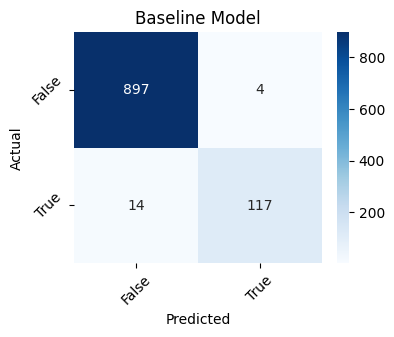

In [25]:
# Evaluate Baseline Logistic Regression model on test set

logreg_mod = LogisticRegression(C=0.4, class_weight='balanced', random_state=2)

start_time = time.time()
logreg_mod.fit(X_train_vec, y_train)
train_time = round(time.time() - start_time, 2)

print(f"Training Time: {train_time} seconds")
evaluate_predictions(logreg_mod, X_test_vec, y_test, "Baseline Model")

### Evaluation of Baseline Model

|Method|F1|Precision|Recall|AUC|Fit Time|
|--------|--------|--------|-------|--------|--------|
|Baseline|0.928571|0.966942|0.89313|0.988969|0.02 sec|

The baseline model seems to do decently, with a fairly high AUC and decent precision score. The recall score is slightly below 90% so there is more room for improvement.

There are only 4 False Positives (actual Ham being marked as Spam), meaning that only 4/901 (0.44%) of the Ham messages in the test data were misclassified. Meanwhile, 14/131 (10.7%) of the Spam messages were misclassified. Part of the issue is likely due to not having as many Spam messages to learn from. The imbalance could also be resulting in some bias towards the Ham class. We also see from comparing the training and cross-validation scores that there is some overfitting, so we could see if reducing the dimensionality reduces the overfitting.

While dimensionality reduction may or may not improve performance, logistic regression can work efficiently with sparse data. Just transforming the matrix can take longer, in addition to fitting the logistic regression classifier with the resulting dense matrix. For classification, the baseline model may be sufficient or even be better in terms of speed and accuracy compared to the models using dimensionality reduction. However, there are other benefits from having fewer features such as more interpretability and being more suitable for clustering.

Logistic regression makes predictions based on the probability of an instance being in a particular class. For this binary classification problem, instances with a probability higher that the threshold of 0.5 will be classified as Spam, and as Ham otherwise.

In [26]:
def misclassified_preds(mod):
    '''
        Return Data Frame of misclassified texts with actual and predicted labels and predict_probas for Spam label
    '''
    
    y_pred = mod.predict(X_test_vec)
    y_pred_proba = mod.predict_proba(X_test_vec)
    misclassified_idxs = y_pred != y_test
    
    df = data.loc[X_test.index][['Text']].copy()
    df['ProcessedText'] = X_test
    df['y_test'] = y_test
    df['y_prob'] = y_pred
    df['y_pred_proba (Spam)'] = y_pred_proba[:, 1]
    df = df.loc[misclassified_idxs].sort_values(by='y_pred_proba (Spam)')
    return df

# Plot histogram of prediction probabilities for Spam class
def plot_pred_probas(mod, title):
    y_pred = mod.predict(X_test_vec)
    y_pred_proba = mod.predict_proba(X_test_vec)[:, 1]  
    misclassified_idxs = y_test != y_pred
    
    plt.figure(figsize=(12, 6))

    # Display counts for each bin
    bins = np.arange(0, 1.1, 0.1)

    # Plot for all predictions
    counts, bins, patches = plt.hist(y_pred_proba, bins=bins, label='All Predictions', stacked=False)
    
    # Display total counts for each bin
    for count, bin_left, bin_right in zip(counts, bins[:-1], bins[1:]):
        plt.text((bin_left + bin_right) / 2, count, str(f"Total: {int(count)}"), ha='center', va='bottom')

    # Plot incorrect predictions
    plt.hist(y_pred_proba[misclassified_idxs], bins=bins, label='Incorrect Predictions', stacked=False)

    # Draw vertical line at threshold of 0.5 (on the right are predicted Spam, left are predicted Ham)
    plt.axvline(x=0.5, color='black', linestyle='--')

    plt.title(title)
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.xticks(np.arange(0.0, 1.1, 0.1))
    plt.legend()
    plt.show()

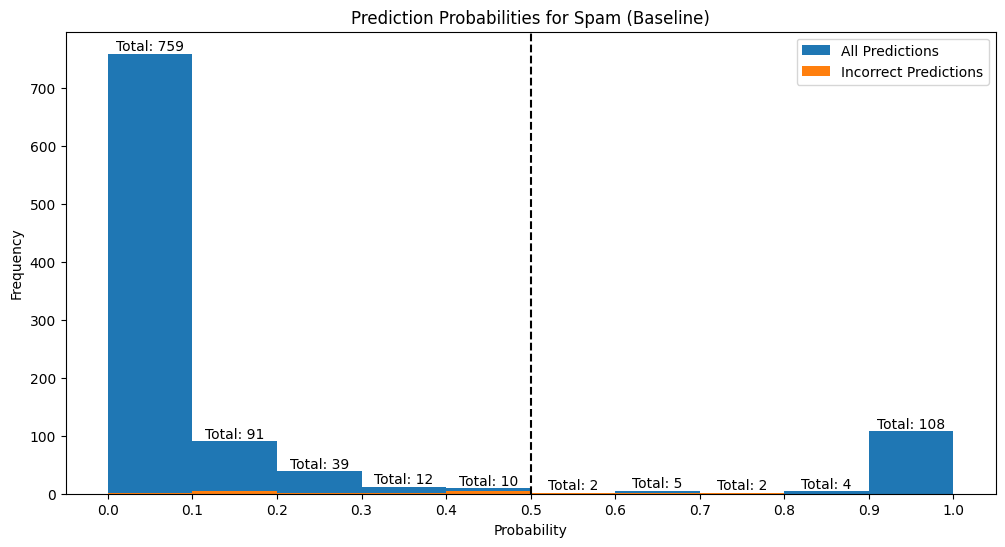

Text  \
2963  Do you ever notice that when you're driving, a...   
3979                                 ringtoneking 84484   
68    Did you hear about the new \Divorce Barbie\"? ...   
760   Romantic Paris. 2 nights, 2 flights from å£79 ...   
5427  Santa Calling! Would your little ones like a c...   
1044  We know someone who you know that fancies you....   
1216  You have 1 new voicemail. Please call 08719181...   
3862  Oh my god! I've found your number again! I'm s...   
3989  (Bank of Granite issues Strong-Buy) EXPLOSIVE ...   
5466  http//tms. widelive.com/index. wml?id=820554ad...   
2861  Adult 18 Content Your video will be with you s...   
762   Urgent Ur å£500 guaranteed award is still uncl...   
2429  Guess who am I?This is the first time I create...   
683   Hi I'm sue. I am 20 years old and work as a la...   
699            K..u also dont msg or reply to his msg..   
3822  Please protect yourself from e-threats. SIB ne...   
1505  Total video converter free download type this ...   
1496  I'm always on yahoo messenger now. Just send t...   

                                          ProcessedText  y_test  y_prob  \
2963   notice drive , go slow idiot drive fast maniac ?    True   False   
3979                                         ringtoneke    True   False   
68     hear new \divorce barbie\ " ? come ken stuff ! "    True   False   
760   romantic paris . night , flight å£ book year ....    True   False   
5427  santa calling ! little one like santa xmas eve...    True   False   
1044            know know fancy . find . pobox , lshb p    True   False   
1216                                  new voicemail . .    True   False   
3862  oh god ! find number ! glad , text xafter msgs...    True   False   
3989  ( bank granite issue strong - buy ) explosive ...    True   False   
5466  http//tms . widelive.com/index . wml?id=ada&fi...    True   False   
2861                        adult content video shortly    True   False   
762   urgent å£ guarantee award unclaimed ! closingd...    True   False   
2429  guess i?this time create web page www.asjesus....    True   False   
683   hi sue . year old work lapdancer . love sex . ...    True   False   
699                           k .. not msg reply msg ..   False    True   
3822  protect e - threat . sib ask sensitive informa...   False    True   
1505  total video converter free download type googl...   False    True   
1496  yahoo messenger . message i.ll mobile mode sha...   False    True   

      y_pred_proba (Spam)  
2963             0.019242  
3979             0.080809  
68               0.154488  
760              0.170310  
5427             0.182057  
1044             0.187231  
1216             0.280037  
3862             0.326813  
3989             0.383906  
5466             0.417311  
2861             0.433376  
762              0.438616  
2429             0.439309  
683              0.492126  
699              0.551689  
3822             0.618192  
1505             0.661336  
1496             0.794493

In [27]:
# Plot prediction probability frequencies and display misclassified instances
plot_pred_probas(logreg_mod, f'Prediction Probabilities for Spam (Baseline)')
misclassified_preds(logreg_mod)

We see that most correct classifications have high probabilities of being in their respective true class. Relatively few instances are in the "unsure" range near the threshold. We do see that there a couple misclassifications within most bins, especially with Spam messages being misclassified as Ham. One thing I could have done was change the threshold from the default 0.5 depending on if I wanted to allow more misclassifications of one class in return for less misclassifications of the other.

Looking at the actual texts of the misclassified instances, we can see what types of texts were hard to classify. In particular, it seems some of the misclassifications are a result of unknown words. The approaches that I will use cannot deal with this type of issue, but there are other methods that can handle it.

There are also instances that lose necessary context when preprocessing and/or converting to a word count matrix representation. For instance, the first misclassified instance above is a Spam message that is worded as a question, but the processed text sounds like a person scolding another person which would be easy to misclassify even for a human.

## Dimensionality Reduction with TruncatedSVD (Truncated Singular Value Decomposition)

TruncatedSVD is a linear dimensionality reduction technique. It is very similar to Principal Component Analysis (PCA), but doesn't require centering of the data and works better on sparse data. Since CountVectorizer produces a sparse matrix, we cannot use PCA without converting it to a dense matrix which will require more memory as well as runtime. TruncatedSVD will give almost the same results as PCA on dense centered data. With our sparse uncentered data, TruncatedSVD will be more efficient in exchange for lower precision.

TruncatedSVD factorizes the matrix into the product of three matrices, X = U x Σ x V. We can use the product U x Σ as our new feature matrix, which will have less features than our original matrix corresponding to the number of components. Like with PCA, the components capture the directions of max variance. We will need to decide how many components are necessary.

One method to choose the number of components to from the cumulative explained variance. Each component has an associated explained variance that indicates the percentage of variance explained. We can plot the sum of the explained variances of the first n components and choose a good number of components.

Another method is to just tune the number of components with grid search.

In [28]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import umap

Runtime: 16.76 seconds


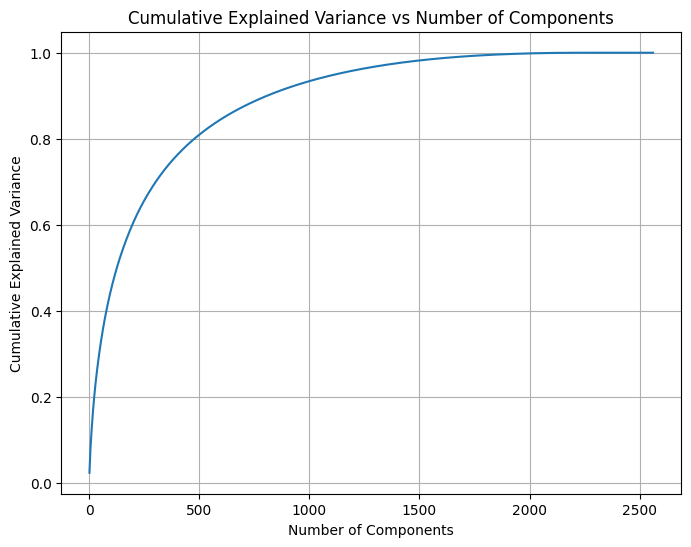

In [29]:
# Plot Cumulative Explained Variance vs Number of Components for TruncatedSVD

start_time = time.time()

n_components = min(X_train_vec.shape) - 1

svd = TruncatedSVD(n_components=n_components, random_state=2)
svd.fit(X_train_vec)

print(f"Runtime: {round(time.time() - start_time, 2)} seconds")

cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

To choose a good number of components from the cumulative explained variance plot, we want to choose a point that explains enough of the variance and where there are minimal gains when increasing the number of components any further. From the plot, we see that it takes almost 500 components to reach 80% cumulative explained variance, and around 800 components for 90% cumulative explained variance. While choosing either of these values does reduce the number of features from the original amount, it is a dense matrix and will actually take significantly longer to run on algorithms such as logistic regression compared to the original sparse matrix.

While it may be common to choose a higher cumulative explained variance like 90% or even 80%, a lower percentage could be sufficient or even preferred if the data is particularly noisy. On the other hand, for PCA or TruncatedSVD we'd normally want most of the variance to be explained with the first several components. In the documentation for TruncatedSVD, it recommends 100 components which only explains about 40% of the variance for this data. This may suggest that TruncatedSVD isn't the best approach to take for this data.

I'll try using gridsearch on a pipeline for TruncatedSVD and Logistic Regression and see how well the model performs on different numbers of components.

100%|██████████| 23/23 [01:22<00:00,  3.58s/it]


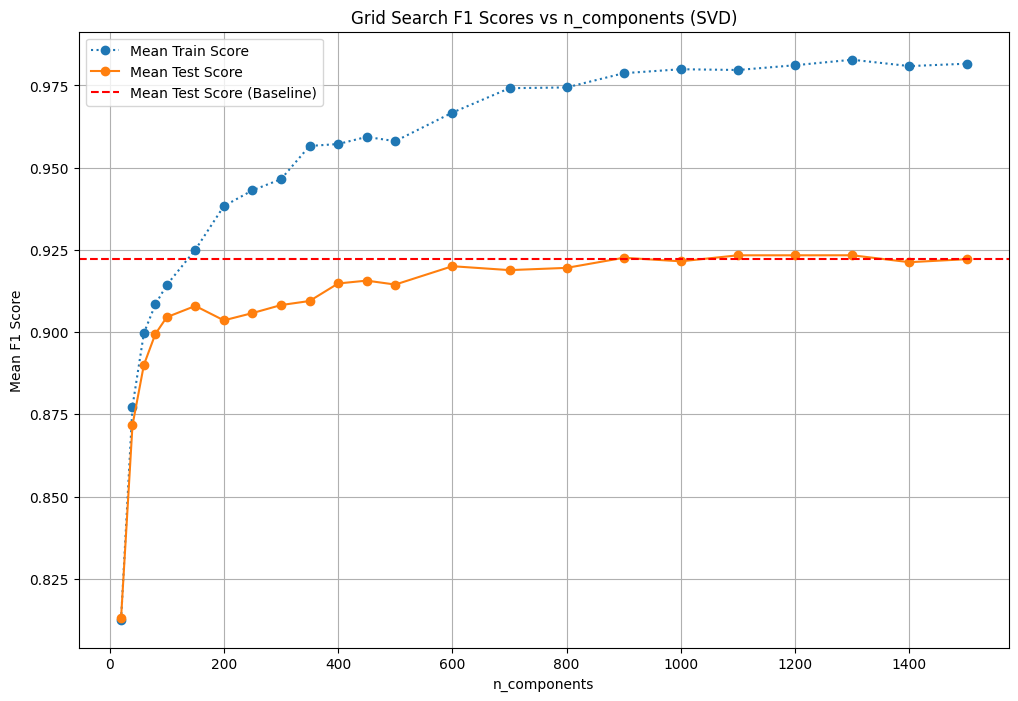

C  n_components  mean_train_score  mean_test_score
0   0.60          1300          0.982817         0.923365
1   0.55          1200          0.981139         0.923357
2   0.50          1100          0.979696         0.923357
3   0.50           900          0.978721         0.922603
4   0.45          1500          0.981608         0.922179
5   0.55          1000          0.979924         0.921529
6   0.45          1400          0.980878         0.921258
7   0.40           600          0.966743         0.920037
8   0.40           800          0.974391         0.919534
9   0.50           700          0.974158         0.918852
10  0.40           450          0.959352         0.915657
11  0.40           400          0.957185         0.914791
12  0.35           500          0.958056         0.914460
13  0.45           350          0.956597         0.909462
14  0.30           300          0.946495         0.908226
15  0.35           150          0.925035         0.907962
16  0.35           250          0.943106         0.905786
17  0.35           100          0.914342         0.904545
18  0.55           200          0.938322         0.903577
19  0.30            80          0.908402         0.899412
20  0.35            60          0.899704         0.890062
21  0.55            40          0.877374         0.871666
22  0.30            20          0.812564         0.813018

Runtime: 82.64 seconds


In [30]:
# For TruncatedSVD + LogReg, perform Grid Search and plot best results for different n_components

start_time = time.time()

results = {
    'params': [],
    'mean_train_score': [],
    'mean_test_score': []
}

logreg = LogisticRegression(class_weight='balanced', random_state=2)

n_comps_list = list(range(20, 100, 20)) + list(range(100, 500, 50)) + list(range(500, 1501, 100))
param_grid = {
    'C': np.arange(0.3, 0.65, 0.05)
}

# For each number in n_comps_list, perform grid search on the C parameter of Logistic Regression
for n_components in tqdm(n_comps_list, total=len(n_comps_list)):
    svd = TruncatedSVD(n_components=n_components, random_state=2)
    X_train_svd = svd.fit_transform(X_train_vec)
    gridsearch = GridSearchCV(logreg, param_grid, scoring='f1', cv=cv, n_jobs=-1, return_train_score=True)
    gridsearch.fit(X_train_svd, y_train)
    params = gridsearch.best_params_
    params['n_components'] = n_components
    results['params'].append(params)
    results['mean_train_score'].append(gridsearch.cv_results_['mean_train_score'][gridsearch.best_index_])
    results['mean_test_score'].append(gridsearch.best_score_)

# From grid search results, plot best train and validation f1 scores for each n_components
plt.figure(figsize=(12, 8))
plt.plot(n_comps_list, results['mean_train_score'], label=f'Mean Train Score', linestyle=':', marker='o')
plt.plot(n_comps_list, results['mean_test_score'], label=f'Mean Test Score', linestyle='-', marker='o')

# Draw horizontal line at f1 score for baseline cross-validation mean test score
plt.axhline(y=0.922191, color='red', linestyle='--', label='Mean Test Score (Baseline)')

plt.xlabel('n_components')
plt.ylabel('Mean F1 Score')
plt.xticks(np.arange(0, n_comps_list[-1] + 1, 200))
plt.title(f'Grid Search F1 Scores vs n_components (SVD)')
plt.legend()
plt.grid(True)

plt.show()

# Print best parameters for each n_components
display(grid_search_results(results))

print(f"Runtime: {round(time.time() - start_time, 2)} seconds")

### Choosing Number of Components for TruncatedSVD

Here, we see that as we decrease the number of components, we reduce overfitting but increase underfitting. Around 900 components, we seem to get similar performance to the baseline model. 600 components also has comparable results, but reducing the components any more starts to decrease performance. However, at around 150 or less components we see less overfitting suggesting better generalization on unseen data.

I will choose 150 components for the TruncatedSVD model since it has a relative good balance between overfitting and underfitting, and is decent reduction from the original number of features. However, for comparison's sake I will also train a model with 600 components as a middle ground between 150 components and no dimensionality reduction.

In [31]:
# Fit TruncatedSVD model with 150 components
svd_mod_150 = Pipeline([
    ('svd', TruncatedSVD(n_components=150, random_state=2)),
    ('logreg', LogisticRegression(C=0.35, class_weight='balanced', random_state=2))
])

start_time = time.time()
svd_mod_150.fit(X_train_vec, y_train)
svd_150_time = round(time.time() - start_time, 2)
print(f"Training Time (150 components): {svd_150_time} seconds")

# Fit and evaluate TruncatedSVD model with 600 components
svd_mod_600 = Pipeline([
    ('svd', TruncatedSVD(n_components=600, random_state=2)),
    ('logreg', LogisticRegression(C=0.4, class_weight='balanced', random_state=2))
])

start_time = time.time()
svd_mod_600.fit(X_train_vec, y_train)
svd_600_time = round(time.time() - start_time, 2)
print(f"Training Time (600 components): {svd_600_time} seconds")

Training Time (150 components): 0.27 seconds
Training Time (600 components): 1.67 seconds


### K-Means Clustering

For each of the three dimensionality reduction techniques, I will cluster using K-means. To choose a good number of clusters, I will create *silhoette plots* for different numbers of clusters, which will plot the *silhoette coefficients* for each instance, which represents how to close it is to others within the same cluster compared to other clusters. A value close to 1 means the instance is well within its cluster and far from other clusters, while a value close to -1 means that it's probably assigned to the wrong cluster.

The silhouette plot also has a dashed red line for the average of the silhoette coefficients. Most instances having a lower coefficient than this line indicates a bad clustering. It is also good to avoid having clusters containing too many instances.

I will also display visualizations of the data as scatterplots, coloring based on clusters as well as marking Spam instances to show how they correspond to certain clusters. Since the reduced dataset still has 150 dimensions, it cannot be easily visualized. Therefore, I will use UMAP which is the third dimensionality reduction technique we will be using, but is also a good tool for visualizing high-dimensional data. UMAP attempts to preserve both local and global structure in the data. While shrinking the dimensions down to 2 dimensions will results in information loss, we can still get a decent visualization of the data and clusters.

In [32]:
def cluster_analysis(X_train, model_name='', n_range=range(2, 6), angles=(45, 45), umap_n_d=None):
    '''
        Print silhouette scores, and display silhouette plots and scatterplots of clusters
        umap_n_d takes tuple (n, d) and uses UMAP with 2 components,
            n_neighbors=n, and min_dist=d for 2D plot
        if umap_n_d is None, does not use UMAP and instead uses first three features as axes
    '''
    if umap_n_d is None: # Plot on first three features
        X = X_train
    else: # Plot with UMAP
        n, d = umap_n_d
        mapper = umap.UMAP(n_neighbors=n, min_dist=d, n_components=2)
        X = mapper.fit_transform(X_train)
    X_spam = X[y_train]
    X_ham = X[~y_train]
    
    for idx, n_clusters in enumerate(n_range):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=2)
        cluster_labels = kmeans.fit_predict(X_train)
        silhouette_vals = silhouette_samples(X_train, cluster_labels)
        silhouette_avg = silhouette_score(X_train, cluster_labels)

        # Make silhoette plot
        y_lower = 10
        yticks = []
        for i in range(n_clusters):
            cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
            cluster_silhouette_vals.sort()
            y_upper = y_lower + len(cluster_silhouette_vals)
            color = cm.nipy_spectral((float(i) + 1) / (n_clusters + 1))
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color)
            yticks.append(y_lower + 0.5 * len(cluster_silhouette_vals))
            y_lower = y_upper + 10
    
        # Draw a vertical line at the average silhouette score
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"Average Silhouette Score: {silhouette_avg:.4f}")
    
        ax1.set_title(f"KMeans Silhouette Plot with {n_clusters} Clusters")
        ax1.set_xlabel("Silhouette Coefficient Values")
        ax1.set_ylabel("Cluster Label")
        ax1.set_yticks(yticks, range(n_clusters))
        ax1.legend()

        colors = cm.nipy_spectral((cluster_labels.astype(float) + 1) / (n_clusters + 1))
        ax2.set_axis_off()

        if umap_n_d is None: # Display 3D plots with the first three features as axes
            ax2 = fig.add_subplot(122, projection='3d')
    
            # Plot Ham points
            ax2.scatter(X_ham[:, 0], X_ham[:, 1], X_ham[:, 2], c=colors[~y_train], s=10, alpha=0.7)
            
            # Plot Spam points with triangle outline
            ax2.scatter(X_spam[:, 0], X_spam[:, 1], X_spam[:, 2], c=colors[y_train], edgecolor='black', s=10, alpha=0.7, marker='D', label='Spam')
        else: # Display 2D UMAP plot
            ax2 = fig.add_subplot(122)
            
            # Plot Ham points
            ax2.scatter(X_ham[:, 0], X_ham[:, 1], c=colors[~y_train], s=10, alpha=0.7)
            
            # Plot Spam points with triangle outline
            ax2.scatter(X_spam[:, 0], X_spam[:, 1], c=colors[y_train], edgecolor='black', s=10, alpha=0.7, marker='D', label='Spam')

        if umap_n_d is None:
            ax2.set_title("Visualization of Clustered Data on First Three Features")
            ax2.set_zlabel("Axis 3")
            ax2.view_init(elev=angles[0], azim=angles[1])
        else:
            ax2.set_title("Visualization of Clustered Data with UMAP plot")
        ax2.set_xlabel("Axis 1")
        ax2.set_ylabel("Axis 2")
        ax2.legend()

        plt.suptitle(
            f"Analysis for KMeans clustering on train data with n_clusters = {n_clusters} ({model_name})",
            fontsize=14,
            fontweight="bold",
        )
        
        plt.tight_layout()
        plt.show()

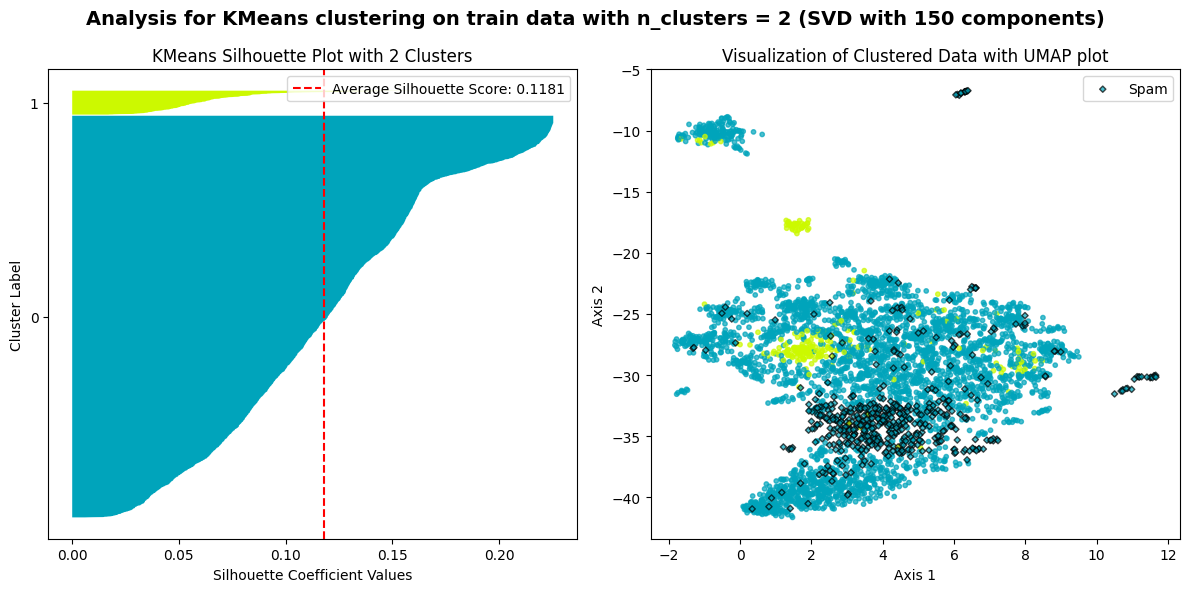

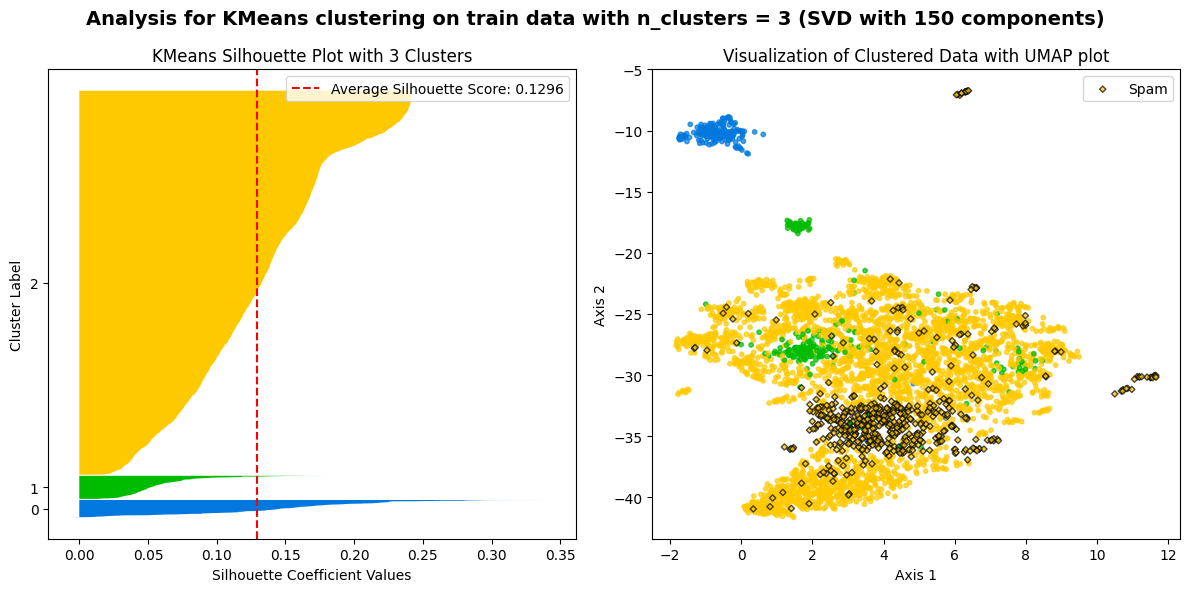

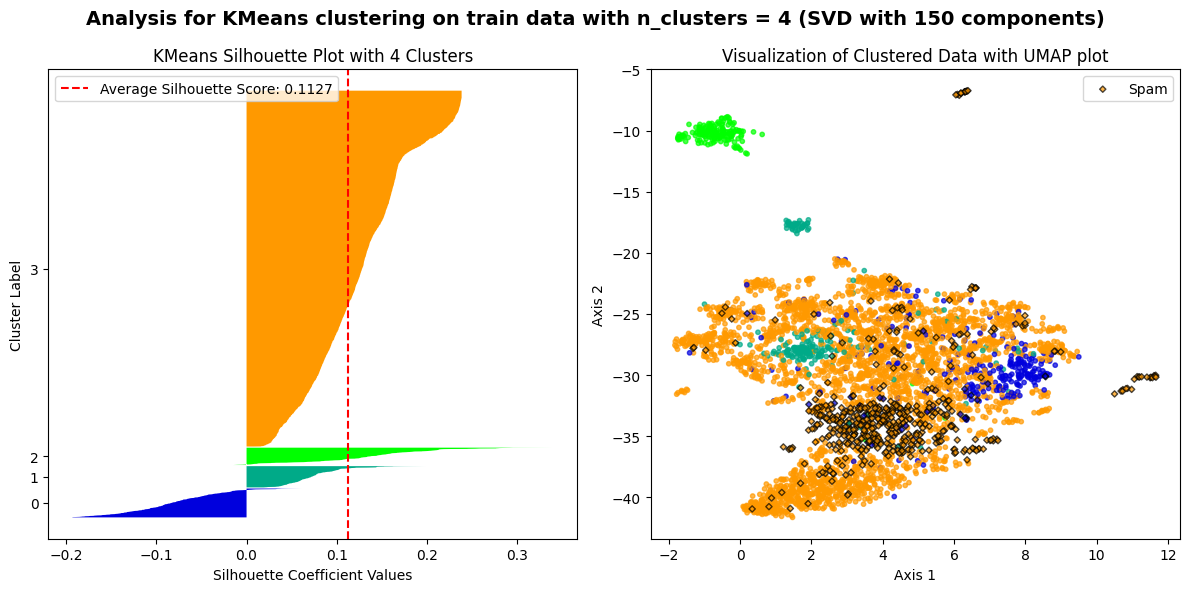

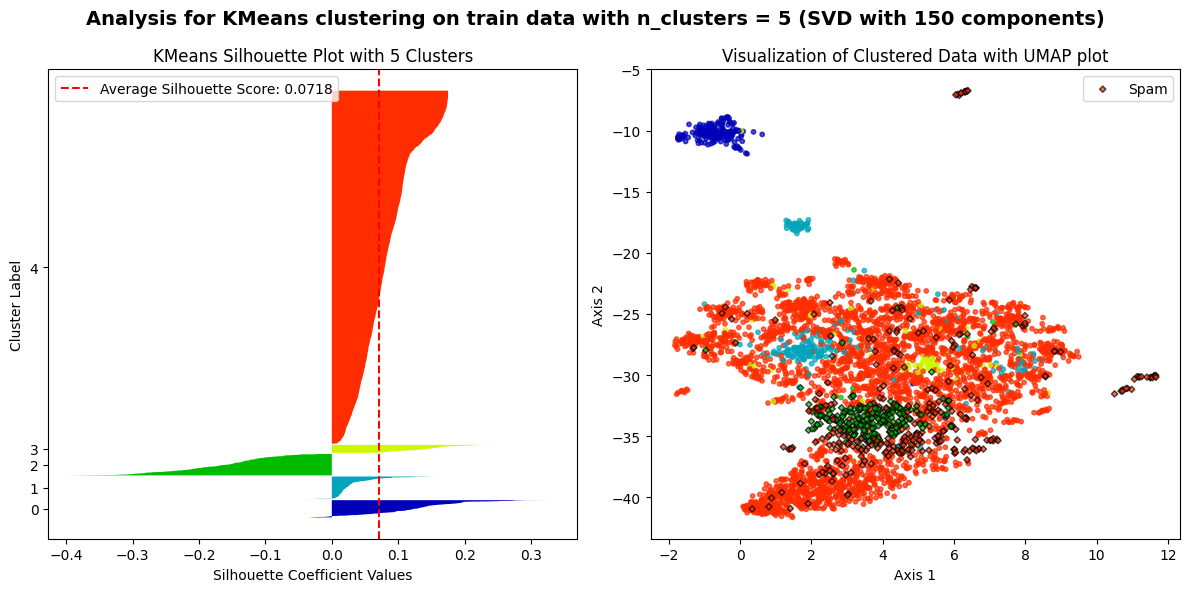

In [33]:
# Analysis for SVD model with 2 to 5 KMeans clusters
X_train_svd = svd_mod_150.named_steps['svd'].transform(X_train_vec)
cluster_analysis(X_train_svd, "SVD with 150 components", angles=(45, 30), umap_n_d=(30, 0.7))

### Analysis of Clusters

First, we see that the average silhoette scores are quite low. We also notice that even with 5 clusters, one of the clusters stays quite large. Either the data itself doesn't cluster well, or we may want to use a different clustering method.

Adding a 5th cluster does seem to create a cluster that captures a decent number of the Spam instances.

Let's look at some of the example texts that are closest to the centroids of each cluster when we have 5 clusters.

In [34]:
# Prints examples closest to each KMeans cluster
def cluster_examples(X, n_clusters, n_examples, components=None):
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=2)
    kmeans.fit(X)
    distances = pairwise_distances(X, kmeans.cluster_centers_)
    closest_points = {}
    
    for cluster_id in range(kmeans.n_clusters):
        cluster_distances = distances[:, cluster_id]
        closest_indices = np.argsort(cluster_distances)[:n_examples]
        print(f"Cluster {cluster_id}")
        for i in closest_indices:
            print(f"{'Spam' if y_train.iloc[i] else 'Ham'}: {X_train.iloc[i]}")
        print()

In [35]:
# Print 10 examples closest to the centroids of each of 5 clusters
cluster_examples(X_train_svd, n_clusters=5, n_examples=10)

Cluster 0
Ham: bold & lt;#&gt ; .
Ham: & lt;#&gt ; mca . conform .
Ham: operate & lt;#&gt ;
Ham: dai & lt;#&gt ; naal eruku .
Ham: s:)s.nervous & lt;#&gt ; :)
Ham: marrow . d & lt;#&gt ; aha .
Ham: & lt;#&gt ; buck
Ham: , squeeze & lt;#&gt ; buck dad
Ham: turn heater ? heater set & lt;#&gt ; degree .
Ham: probably & lt;#&gt ; % .

Cluster 1
Ham: gam go outstanding inning .
Ham: r ì _ go ?
Ham: go aunty !
Ham: go ride bike ?
Ham: ì _ noe ben go ?
Ham: . queen . go royal wedding
Ham: fair , go ?
Ham: go mall ?
Ham: roger . weû÷re probably go rem
Ham: dad go oredi ...

Cluster 2
Spam: xclusive@clubsaisai morow soiree speciale zouk nichols paris.free roses ladies ! ! ! info :
Ham: / free . nalla adi entey nattil kittum
Ham: free pa .
Ham: yup free ...
Ham: free sir .
Ham: sir goodmorning , free .
Spam: free > ringtone!reply real
Spam: network operator . service free . t & c visit .biz
Ham: study . i.ll free weekend .
Ham: sport type .. lyk footbl , crckt ..

Cluster 3
Ham: oh ? ? air ? ta

Cluster 4 is the largest cluster so it seems to be the "miscellaneous" group where texts go if they fit into any of the other clusters. Looking at the other clusters, we can clearly see how they were clustered. Each cluster seems to be centered on instances containing specific words. From Clusters 0 to 4, they respectively contain the words "lt;#&gt", "go", "free", and "oh". We do see in Cluster 2 that the 10th example does not contain "free", so single words aren't the deciding factor as to whether an instance belongs to a specific cluster.

Since the original data is based on word counts and TruncatedSVD results in a lower-dimensional projection of the data onto orthogonal axes, it preserves a good amount of the original structure. So it makes sense that k-means is clustering instances containing certain words together. However, the clusters seem highly reliant on specific words, which seems to be resulting in a large "leftover" pile. Even if we increase the number of clusters, it will likely just create another small cluster. In other words, we have one large useless cluster and several smaller overly-specific clusters.

With K-means, we can also assign new instances to clusters. I'll assign clusters for each test instance, and see how many Ham and Spam instances are assigned to each cluster.

In [36]:
def kmeans_predictions(X_train, X_test, n_clusters=5):
    '''
        Print kmeans test predictions grouped by clusters and true labels
    '''
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=2)
    kmeans.fit(X_train)
    clusters = kmeans.predict(X_test)
    labels = ["Spam" if label else "Ham" for label in y_test]
    df = pd.DataFrame({
        'cluster': clusters,
        'label': labels
    })
    
    # Group and count
    cluster_counts = df.groupby(['cluster', 'label']).size().unstack(fill_value=0)
    
    print("Test Cluster Predictions:")
    print(cluster_counts)

In [37]:
# Print kmeans test predictions
X_test_svd = svd_mod_150.named_steps['svd'].transform(X_test_vec)
kmeans_predictions(X_train_svd, X_test_svd)

Test Cluster Predictions:
label    Ham  Spam
cluster           
0         44     0
1         59     1
2          1    50
3         20     1
4        777    79


Clusters 0, 1, and 3 mostly contain Ham messages with only 2 Spam messages. Meanwhile, Cluster 3 contains mostly Spam messages with only 1 Ham messages. This is probably due to containing words that are more common for specific classes. Cluster 4 has the remaining instances, and as a result has many of both Ham and Spam messages.

Training Time: 0.27 seconds
Cumulative Explained Variance: 53.73%
              F1  Precision    Recall       AUC
Scores  0.921875      0.944  0.900763  0.983606


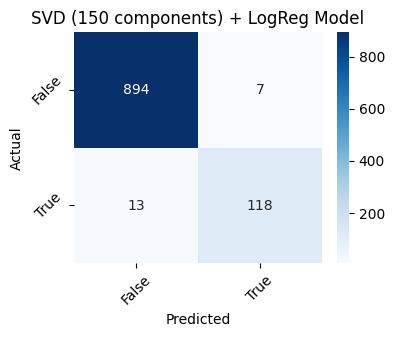

In [38]:
# Evaluate TruncatedSVD model with 150 components

print(f"Training Time: {svd_150_time} seconds")
cumulative_ev = svd_mod_150[0].explained_variance_ratio_.sum()
print(f"Cumulative Explained Variance: {cumulative_ev * 100:.2f}%")
evaluate_predictions(svd_mod_150, X_test_vec, y_test, f"SVD (150 components) + LogReg Model")

Training Time: 1.67 seconds
Cumulative Explained Variance: 84.45%
             F1  Precision    Recall       AUC
Scores  0.92549   0.951613  0.900763  0.987571


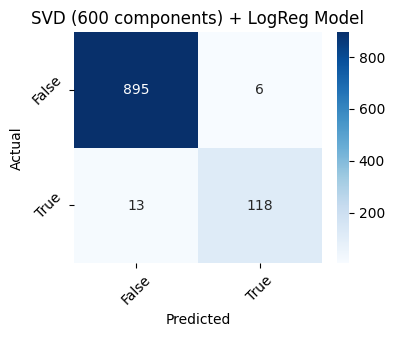

In [39]:
# Evaluate TruncatedSVD model with 600 components
y_pred = svd_mod_600.predict(X_test_vec)

print(f"Training Time: {svd_600_time} seconds")
cumulative_ev = svd_mod_600[0].explained_variance_ratio_.sum()
print(f"Cumulative Explained Variance: {cumulative_ev * 100:.2f}%")
evaluate_predictions(svd_mod_600, X_test_vec, y_test, f"SVD (600 components) + LogReg Model")

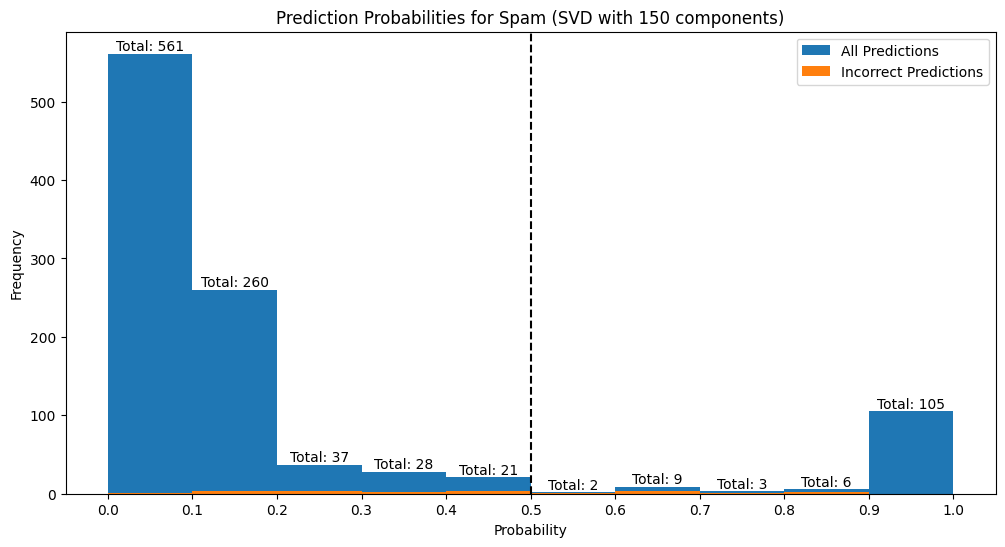

Text  \
2963  Do you ever notice that when you're driving, a...   
1044  We know someone who you know that fancies you....   
3979                                 ringtoneking 84484   
3562  Auction round 4. The highest bid is now å£54. ...   
3989  (Bank of Granite issues Strong-Buy) EXPLOSIVE ...   
68    Did you hear about the new \Divorce Barbie\"? ...   
5427  Santa Calling! Would your little ones like a c...   
2861  Adult 18 Content Your video will be with you s...   
1216  You have 1 new voicemail. Please call 08719181...   
5466  http//tms. widelive.com/index. wml?id=820554ad...   
3862  Oh my god! I've found your number again! I'm s...   
762   Urgent Ur å£500 guaranteed award is still uncl...   
760   Romantic Paris. 2 nights, 2 flights from å£79 ...   
1678  So many people seems to be special at first si...   
3681  Hello, hello, hi lou sorry it took so long 2 r...   
2161  Is she replying. Has boye changed his phone nu...   
1505  Total video converter free download type this ...   
5570  The guy did some bitching but I acted like i'd...   
699            K..u also dont msg or reply to his msg..   
1496  I'm always on yahoo messenger now. Just send t...   

                                          ProcessedText  y_test  y_prob  \
2963   notice drive , go slow idiot drive fast maniac ?    True   False   
1044            know know fancy . find . pobox , lshb p    True   False   
3979                                         ringtoneke    True   False   
3562  auction round . high bid å£ . maximum bid å£ ....    True   False   
3989  ( bank granite issue strong - buy ) explosive ...    True   False   
68     hear new \divorce barbie\ " ? come ken stuff ! "    True   False   
5427  santa calling ! little one like santa xmas eve...    True   False   
2861                        adult content video shortly    True   False   
1216                                  new voicemail . .    True   False   
5466  http//tms . widelive.com/index . wml?id=ada&fi...    True   False   
3862  oh god ! find number ! glad , text xafter msgs...    True   False   
762   urgent å£ guarantee award unclaimed ! closingd...    True   False   
760   romantic paris . night , flight å£ book year ....    True   False   
1678  people special sight , remain special till sig...   False    True   
3681  hello , hello , hi lou sorry take long reply- ...   False    True   
2161                   reply . boye change phone number   False    True   
1505  total video converter free download type googl...   False    True   
5570  guy bitching act like interested buy week give...   False    True   
699                           k .. not msg reply msg ..   False    True   
1496  yahoo messenger . message i.ll mobile mode sha...   False    True   

      y_pred_proba (Spam)  
2963             0.024897  
1044             0.109047  
3979             0.120108  
3562             0.151678  
3989             0.152589  
68               0.218273  
5427             0.243354  
2861             0.264186  
1216             0.313517  
5466             0.380005  
3862             0.403040  
762              0.462987  
760              0.474343  
1678             0.534157  
3681             0.614169  
2161             0.624861  
1505             0.625746  
5570             0.754205  
699              0.827693  
1496             0.897798

In [40]:
# Plot prediction probability frequencies and display misclassified instances
plot_pred_probas(svd_mod_150, f'Prediction Probabilities for Spam (SVD with 150 components)')
misclassified_preds(svd_mod_150)

### Evaluation of TruncatedSVD + LogReg Models (150 and 600 components)

|Method|Components|F1|Precision|Recall|AUC|Fit Time|
|--------|--------|--------|-------|--------|--------|--------|
|Baseline|N/A|0.928571|0.966942|0.89313|0.988969|0.02 sec|
|SVD|150|0.921875|0.944|0.900763|0.983606|0.19 sec|
|SVD|600|0.92549|0.951613|0.900763|0.987571|1.2 sec|

150 components has 53.73% explained variance while 600 components has 84.45% explained. Despite that, 150 components only performs slightly worse. The model training time with 600 components also takes a bit longer. While it's only 1.2 seconds, it will likely scale worse with larger datasets, especially since it is a dense matrix.

Comparing the TruncatedSVD with 150 components model with the Baseline model, the former has slightly higher recall but lower precision. This difference may be negligible. If we compare the confusion matrices, TruncatedSVD resulted in one less False Negative but two more False Positives, which probably isn't enough to conclude any significant different either way. While reducing the dimensionality didn't seem to improve performance, we were able to reduce the number of features from 2562 to just 150.

In this case, it's probably better to train the Logistic Regression classifier directly on the raw sparse matrix rather than first using TruncatedSVD to reduce the dimensionality. However, the reduced feature set does seem to capture some of the latent structure in the data.

## Dimensionality Reduction with NMF (Non-Negative Matrix Factorization)

NMF is another linear matrix factorization technique for dimensionality reduction that original matrix must have non-negative values. This constraint is fulfilled for our matrix since word counts cannot be negative.

Unlike SVD which captures the directions of max variance, NMF are assumes the data points are linear combinations of components. While the components in SVD must be orthogonal, we do not have this constraint for NMF. NMF decomposes the matrix into the product of two matrices W x H, where W is a n x d matrix and H is a d x m matrix. The value d corresponds to the number of components. Each component can represent a *latent topic* which is useful for topic modeling. We can use W as our new reduced feature matrix.

Compared to TruncatedSVD, the results of NMF are more interpretable, especially for topic modeling, and can result in sparse non-negative features. Meanwhile, TruncatedSVD preserves the original structure better and may scale better with larger datasets.

In [41]:
from sklearn.decomposition import NMF

100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


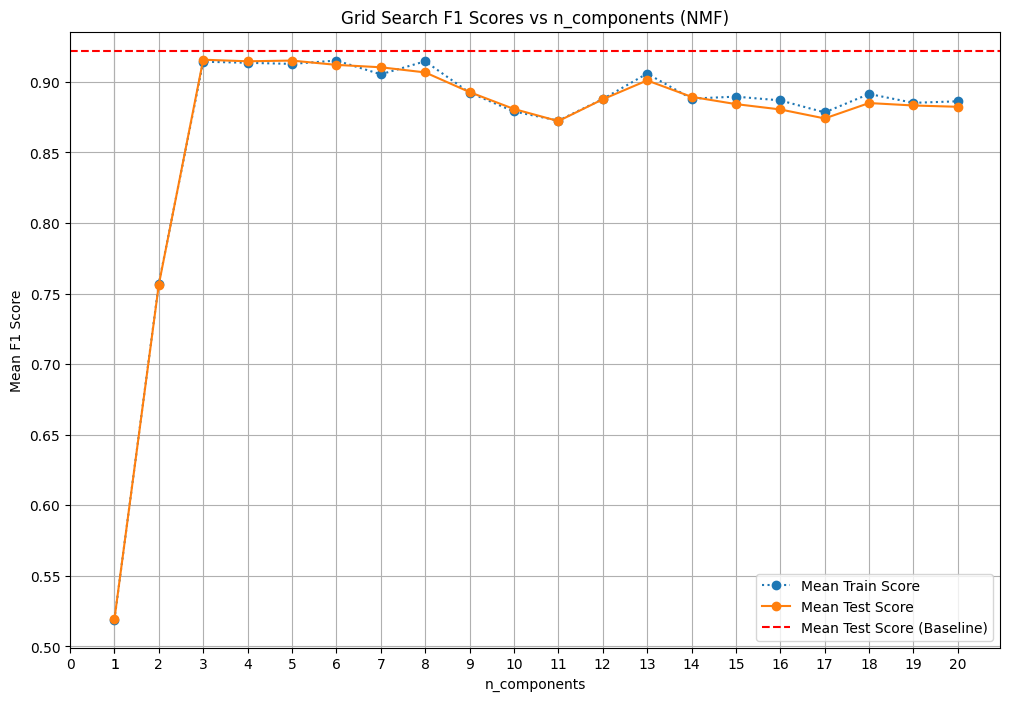

C  n_components  mean_train_score  mean_test_score
0  2.4             3          0.914282         0.915681
1  2.8             5          0.912707         0.915070
2  2.8             4          0.913508         0.914580
3  2.6             6          0.915110         0.912027
4  2.2             7          0.905342         0.910331

Runtime: 25.25 seconds


In [42]:
# For NMF + LogReg, perform Grid Search and plot best results for different n_components

start_time = time.time()

results = {
    'params': [],
    'mean_train_score': [],
    'mean_test_score': []
}

logreg = LogisticRegression(class_weight='balanced', random_state=2)

n_comps_list = list(range(1, 21))
param_grid = {
    'C': np.arange(1, 3.1, 0.2)
}

# For each number in n_comps_list, perform grid search on the C parameter of Logistic Regression
for n_components in tqdm(n_comps_list, total=len(n_comps_list)):
    nmf = NMF(n_components=n_components, solver='mu', beta_loss='kullback-leibler', max_iter=500, random_state=2)
    X_train_nmf = nmf.fit_transform(X_train_vec)
    gridsearch = GridSearchCV(logreg, param_grid, scoring='f1', cv=cv, n_jobs=-1, return_train_score=True)
    gridsearch.fit(X_train_nmf, y_train)
    params = gridsearch.best_params_
    params['n_components'] = n_components
    results['params'].append(params)
    results['mean_train_score'].append(gridsearch.cv_results_['mean_train_score'][gridsearch.best_index_])
    results['mean_test_score'].append(gridsearch.best_score_)

# From grid search results, plot best train and validation f1 scores for each n_components
plt.figure(figsize=(12, 8))
plt.plot(n_comps_list, results['mean_train_score'], label=f'Mean Train Score', linestyle=':', marker='o')
plt.plot(n_comps_list, results['mean_test_score'], label=f'Mean Test Score', linestyle='-', marker='o')

# Draw horizontal line at f1 score for baseline cross-validation mean test score
plt.axhline(y=0.922191, color='red', linestyle='--', label='Mean Test Score (Baseline)')

plt.xlabel('n_components')
plt.ylabel('Mean F1 Score')
plt.xticks([0, 1] + n_comps_list)
plt.title(f'Grid Search F1 Scores vs n_components (NMF)')
plt.legend()
plt.grid(True)

plt.show()

# Print 5 best parameters for each n_components
display(grid_search_results(results)[:5])

print(f"Runtime: {round(time.time() - start_time, 2)} seconds")

### Choosing Number of Components for NMF

No matter how many components we have, the cross validation score never seems to reach that of the Baseline model although it does get close. Most notably, however, the training and cross validation scores are nearly the same across the different numbers of components. Compared to TruncatedSVD, with NMF it looks like we can reduce the number of features to just single digits. NMF may be more suitable for this dataset than SVD.

It's clear that we need at least 3 components. After 3 components, adding more components doesn't seem to help with Spam detection. In fact, starting at around 7-8, performance actually gets worse. It's likely that the 3rd component corresponds to the latent topic representing Spam messages. For general topic modeling, it may make sense to add a few more components. While the extra components don't particular improve the Spam detection problem, it may be able to find latent topics among the Ham instances. But for the purposes of this problem, I will use 3 components.

Another benefit of needing only 3 components is that it is very easy to visualize as I only need to plot the points on a 3D scatterplot using the components as the axes.

In [43]:
def draw_nmf_plots(W, c, title='NMF Plot (Train)', labels=['Ham', 'Spam']):
    '''
        Display 3D plots where the first 3 NMF components are the axes
        It displays the same plot four times from different angles
    '''
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(221, projection='3d')
    scatter = ax.scatter(W[:, 0], W[:, 1], W[:, 2], c=c, s=10, alpha=0.7)
    ax.set_xlabel('Topic 1')
    ax.set_ylabel('Topic 2')
    ax.set_zlabel('Topic 3')
    ax.set_title(title)
    handles, _ = scatter.legend_elements()
    ax.legend(handles, labels)
    ax.view_init(elev=45, azim=45)
    
    ax = fig.add_subplot(222, projection='3d')
    scatter = ax.scatter(W[:, 0], W[:, 1], W[:, 2], c=c, s=10, alpha=0.7)
    ax.set_xlabel('Topic 1')
    ax.set_ylabel('Topic 2')
    ax.set_zlabel('Topic 3')
    ax.set_title(title)
    handles, _ = scatter.legend_elements()
    ax.legend(handles, labels)
    ax.view_init(elev=85, azim=0)
    
    ax = fig.add_subplot(223, projection='3d')
    scatter = ax.scatter(W[:, 0], W[:, 1], W[:, 2], c=c, s=10, alpha=0.7)
    ax.set_xlabel('Topic 1')
    ax.set_ylabel('Topic 2')
    ax.set_zlabel('Topic 3')
    ax.set_title(title)
    handles, _ = scatter.legend_elements()
    ax.legend(handles, labels)
    ax.view_init(elev=5, azim=90)
    
    ax = fig.add_subplot(224, projection='3d')
    scatter = ax.scatter(W[:, 0], W[:, 1], W[:, 2], c=c, s=10, alpha=0.7)
    ax.set_xlabel('Topic 1')
    ax.set_ylabel('Topic 2')
    ax.set_zlabel('Topic 3')
    ax.set_title(title)
    handles, _ = scatter.legend_elements()
    ax.legend(handles, labels)
    ax.view_init(elev=5, azim=0)
    
    # Show the plot
    plt.show()

In [44]:
# Fit NMF + LogReg Model with 3 components

n_components = 3

nmf_mod = Pipeline([
    ('nmf', NMF(n_components=n_components, solver='mu', beta_loss='kullback-leibler', random_state=2)),
    ('logreg', LogisticRegression(C=2.4, class_weight='balanced', random_state=2))
])

start_time = time.time()
nmf_mod.fit(X_train_vec, y_train)
train_time = round(time.time() - start_time, 2)

print(f"Training Time: {train_time} seconds")

Training Time: 0.49 seconds


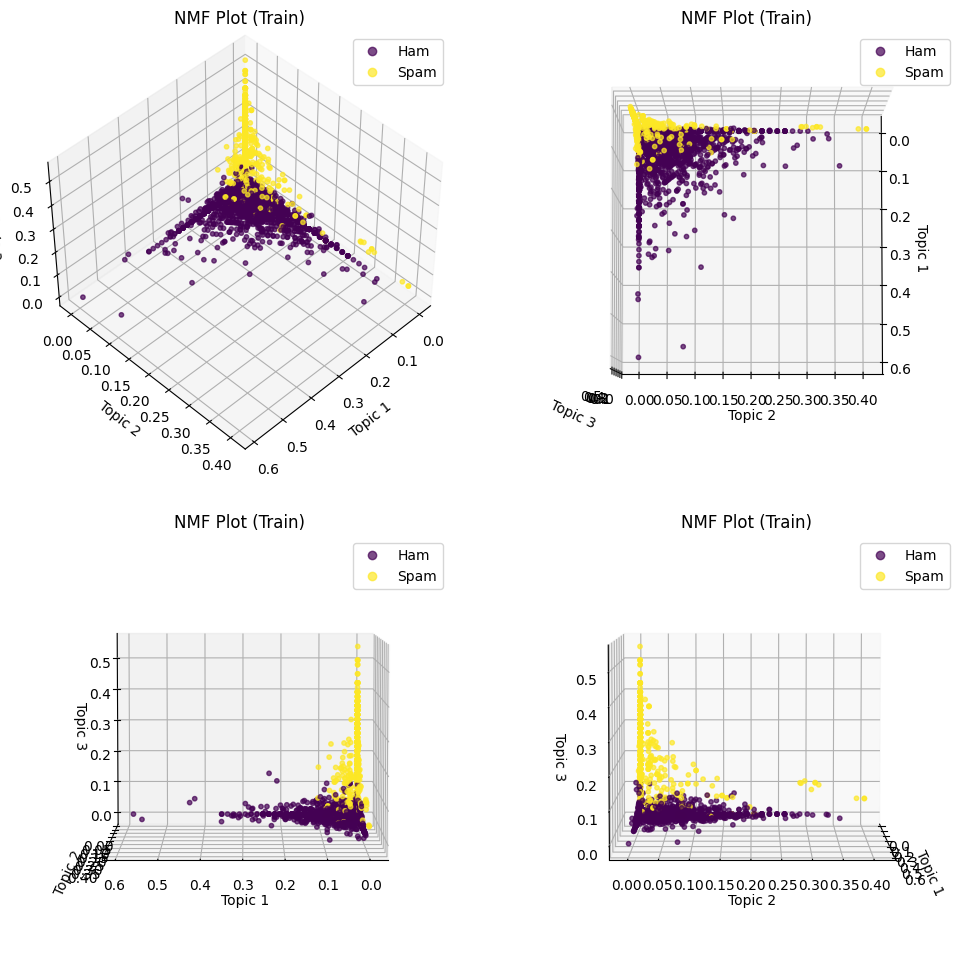

In [45]:
# 3D plot for training data with 3 components as axes
X_train_nmf = nmf_mod.named_steps['nmf'].transform(X_train_vec)
draw_nmf_plots(X_train_nmf, y_train)

In [46]:
# Print top 30 words for each component
top_n = 30
words = vectorizer.get_feature_names_out()

for i, topic in enumerate(nmf_mod.named_steps['nmf'].components_):
    top_indices = topic.argsort()[-top_n:][::-1]
    top_words = [words[index] for index in top_indices]
    print(f"Topic {i + 1}: {', '.join(top_words)}\n")

Topic 1: know, gt, lt, like, lt gt, get, not, need, say, leave, tell, yeah, pls, let, want, right, come, thing, sure, buy, think, time, friend, good, yes, life, place, money, mean, sorry

Topic 2: go, ok, come, love, day, good, home, lor, time, da, want, get, think, hope, hey, not, miss, today, meet, hi, night, wat, babe, tell, work, happy, wait, thank, pick, way

Topic 3: free, text, txt, stop, reply, mobile, claim, win, prize, www, cash, new, min, phone, message, service, urgent, number, week, uk, tone, contact, msg, nokia, award, com, customer, line, offer, try



### Analysis of Latent Topics

When we plot the points using the three components as axes, the data for the most part seems linearly divisible between the two classes. We notice that Spam messages generally have lower values for Topics 1 and 2 and relatively higher values for Topic 3. Meanwhile, Ham values can have low or high values for Topics 1 and 2 while having a lower value for Topic 3. As suspected earlier, the third component corresponds to a "Spam topic".

With NMF we also have the topic x term matrix H in which each term as a weight for each topic. We can get a list of representative terms for each topic by getting the terms with the highest weights for each topic.

Looking at the top words for Topic 3, we see words that we would expect to see from Spam messages. We also see a different set words for Topics 1 and 2. While it's not clear exactly what these topics represent, one possibility is that Topic 2 might be between people with intimate relationships (between family members or romantic partners) as it includes words like "love", "home", and "babe". Topic 1 does seem to include familiar language, while not as intimate as in Topic 2, seems casual including words like "lt gt" (which may indicate emojis), "yeah", "pls", "sure" so it could indicate some level of comfort between two individuals.

Points closer to the origin would indicate messages further away from these three Topics. These would include texts with completely unknown terms that wouldn't provide any information to help classify it. It's also likely that many of these messages are very short messages which contain less information. There may also be points that have low values for the three topics but might fall under another topic if we were to allow for more components.

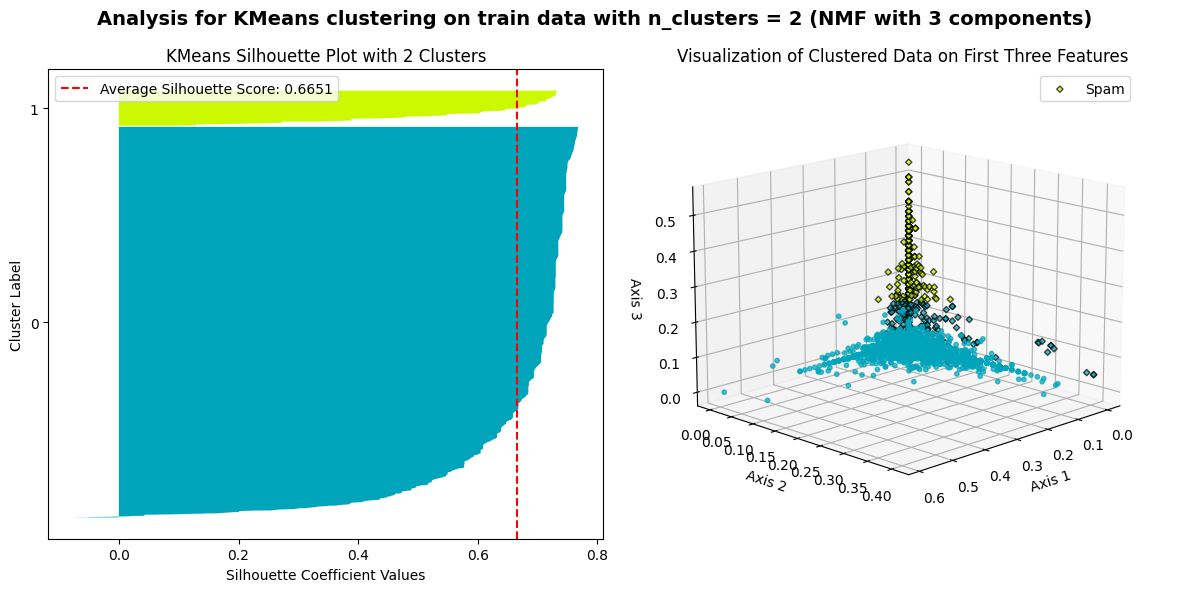

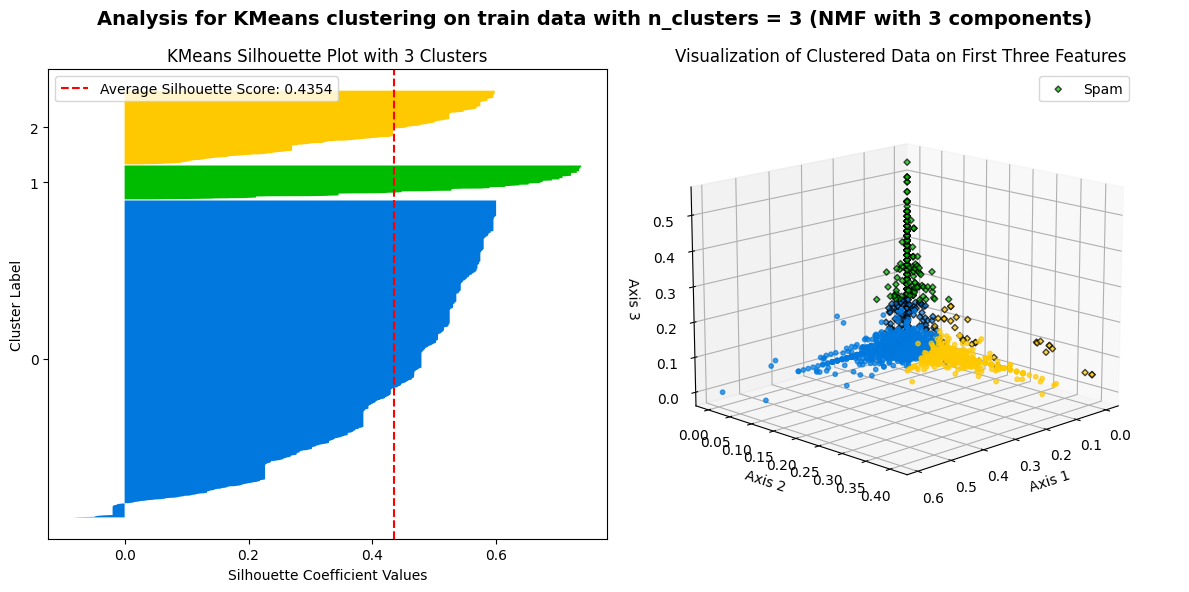

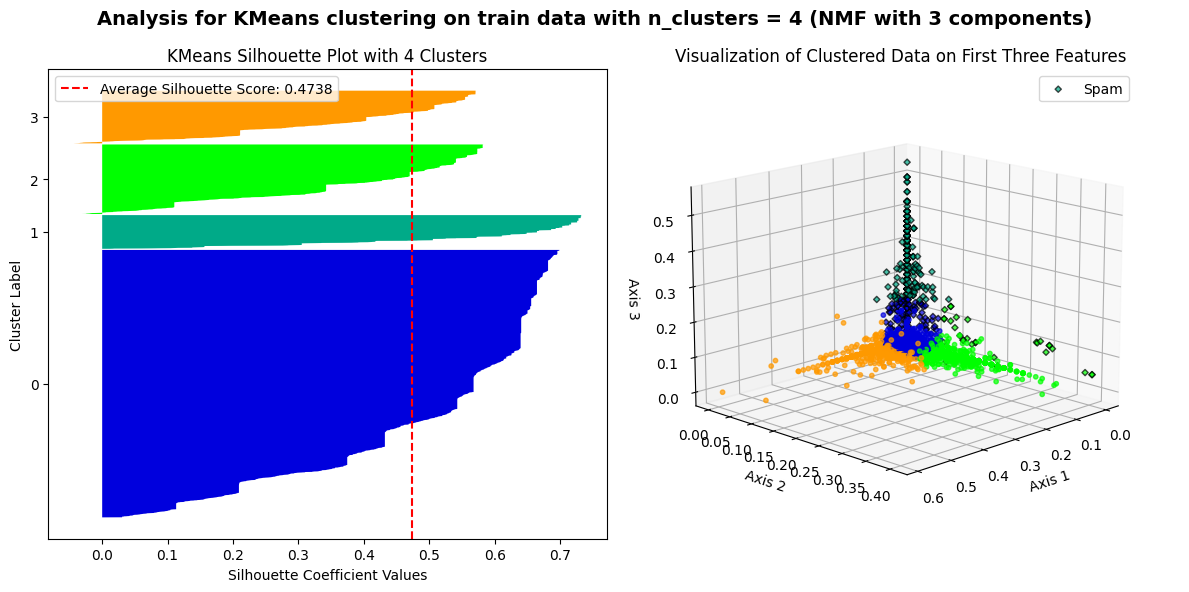

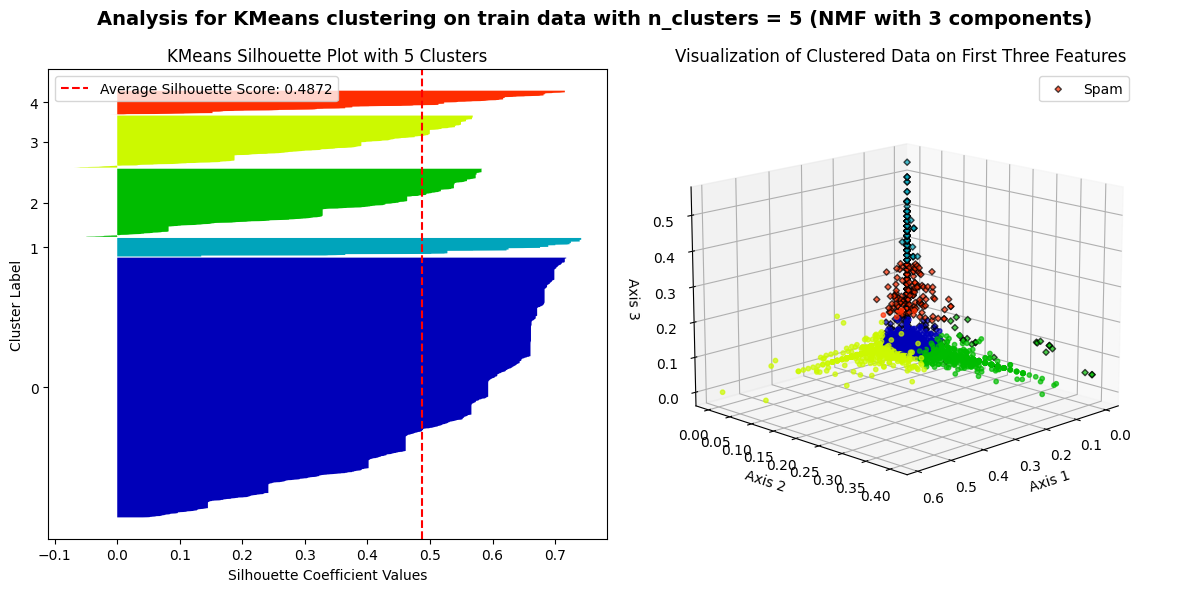

In [47]:
# Analysis for NMF model with 2 to 5 KMeans clusters
cluster_analysis(X_train_nmf, f"NMF with {n_components} components", angles=(15, 45))

### Analysis of Clusters

We get much better clustering results compared to clustering on the TruncatedSVD reduced matrix.

First, we see that with 2 clusters, K-means separates most of the Spam instances from the Ham instances. It does seem to have some issue with the points on the boundary, however. With 4 clusters, we get now have 3 clusters that correspond to each of the 3 topics and a 4th cluster for the data points that have low values for all 3 topics.

With 5 clusters, the "Spam" cluster gets split into two separate clusters. However, the bottom cluster captures more of the Spam instances, although also taking in a few Ham instances as well.

We'll now look at some of the central texts for each cluster.

In [48]:
# Print 10 examples closest to the centroids of each of 5 clusters
cluster_examples(X_train_nmf, n_clusters=5, n_examples=10)

Cluster 0
Ham: email yifeng oredi .. ì _ fr ..
Ham: dear go rubber place
Ham: think + da . wil .
Ham: sure sick time ?
Ham: sleep time.you ?
Ham: okay ... wait ah
Ham: okay . soon . good
Ham: place want da .
Ham: yeah , bed , midnight
Ham: near kalainar tv office.thenampet

Cluster 1
Spam: win year supply cd store choice worth å£ & enter å£ weekly draw txt music ts&cs www . ldew.com.subs + winppmx
Spam: free entry grprizes wkly comp chance win late nokia , psp å£ cash wk . txt great http//www.grprizes.com
Spam: chance ! claim å£ worth discount voucher today ! text shop ! savamob , offer mobile ! t cs savamob pobox , muz . å£. sub .
Spam: free entry weekly comp chance win ipod . txt pod entry ( std txt rate ) t&c apply detail +
Spam: new mobiles , ! txt : nokia : & collect today!from å£ www.-tc.biz optout .gbp / mtmsg
Spam: mth half price orange line rental & late camera phone free . phone mth ? mobilesdirect free update ! orstoptxt
Spam: new mobiles , ! txt : nokia : & collect today ! 

Clusters 1 and 4 clearly represent Spam messages. Cluster 1 has higher values for Topic 3, which may be because they contain many more "spam words". The Cluster 4 words seem to include more neutral words while still having a decent amount of spam words.

Cluster 0 (the "miscellaneous" group) looks to have messages that are shorter on average. It seems to consist of both short neutral messages as well as short "unique" messages like "near kalainar tv office.thenampet" containing possibly unknown words (including possible typos) that cannot be handled well by the current approaches.

Clusters 2 and 3 correspond to Topics 2 and 1 respectively, and while there still doesn't seem to a clear single topic that describes each, it does look like they each represent messages of some level of familiarity.

In [49]:
# Print kmeans test predictions
X_test_nmf = nmf_mod.named_steps['nmf'].transform(X_test_vec)
kmeans_predictions(X_train_nmf, X_test_nmf)

Test Cluster Predictions:
label    Ham  Spam
cluster           
0        670    18
1          0    38
2        120     5
3        111     4
4          0    66


When we assign clusters to the test data, we get better separation between Ham and Spam clusters compared to the TruncatedSVD clusters. However, K-means assigns points to the nearest cluster, so Spam instances with relative lower values for Topic 3 may end up closer to Ham clusters.

We'll now evaluate the Logistic Regression classifier trained on the reduced feature matrix produced by NMF with 3 components.

Training Time: 0.49 seconds
              F1  Precision    Recall       AUC
Scores  0.931727   0.983051  0.885496  0.976201


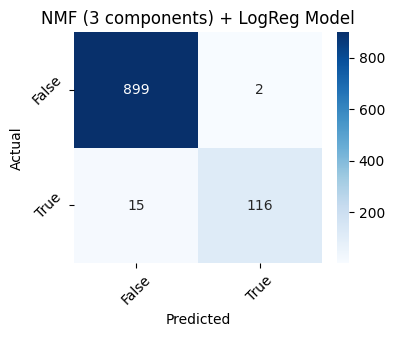

In [50]:
# Evaluate NMF model on test set
y_pred = nmf_mod.predict(X_test_vec)

print(f"Training Time: {train_time} seconds")
evaluate_predictions(nmf_mod, X_test_vec, y_test, f"NMF (3 components) + LogReg Model")

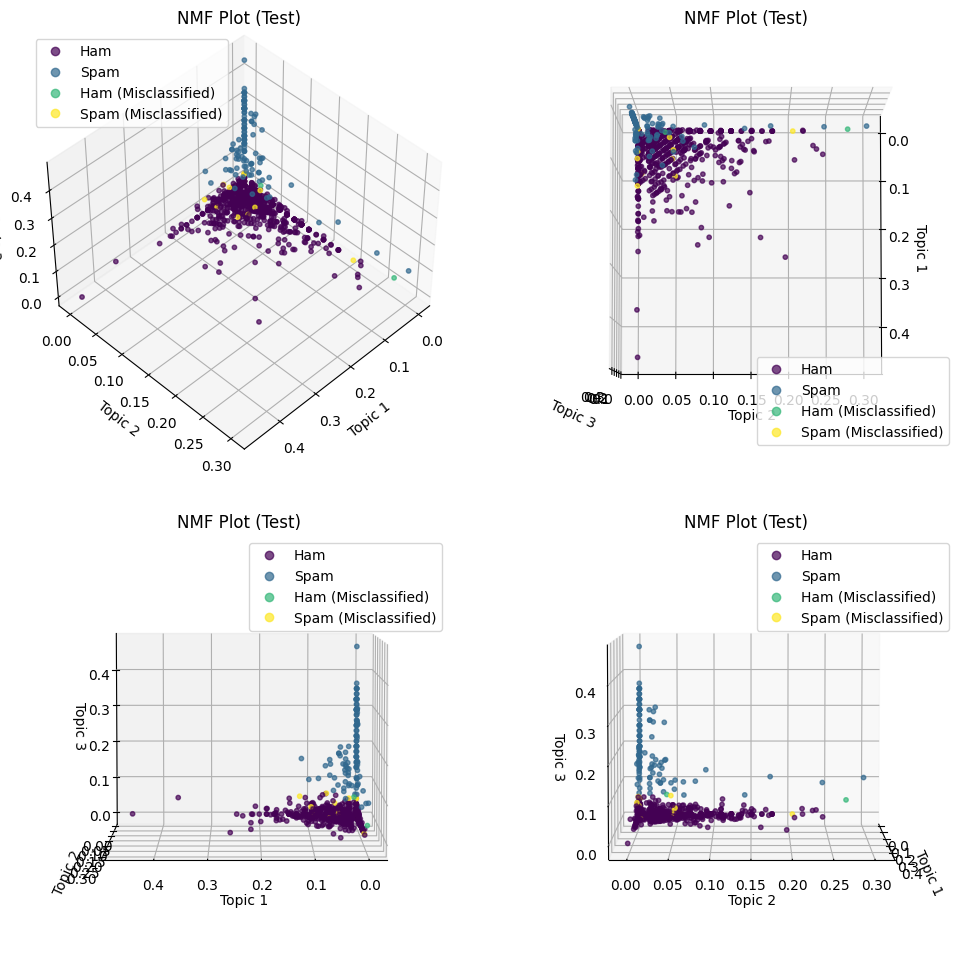

In [51]:
# 3D plot for test data with 3 components as axes

c = []
indices = []
X_test_nmf = nmf_mod.named_steps['nmf'].transform(X_test_vec)

# Get Spam row indices, and mark 1 or 0 in list c whether prediction was correct or not
for i, (a, b) in enumerate(zip(y_test, y_pred)):
    if a == b: # If correctly classified
        c.append(a)
    else: # If misclassified
        c.append(a + 2)

draw_nmf_plots(X_test_nmf, c, 'NMF Plot (Test)', ['Ham', 'Spam', 'Ham (Misclassified)', 'Spam (Misclassified)'])

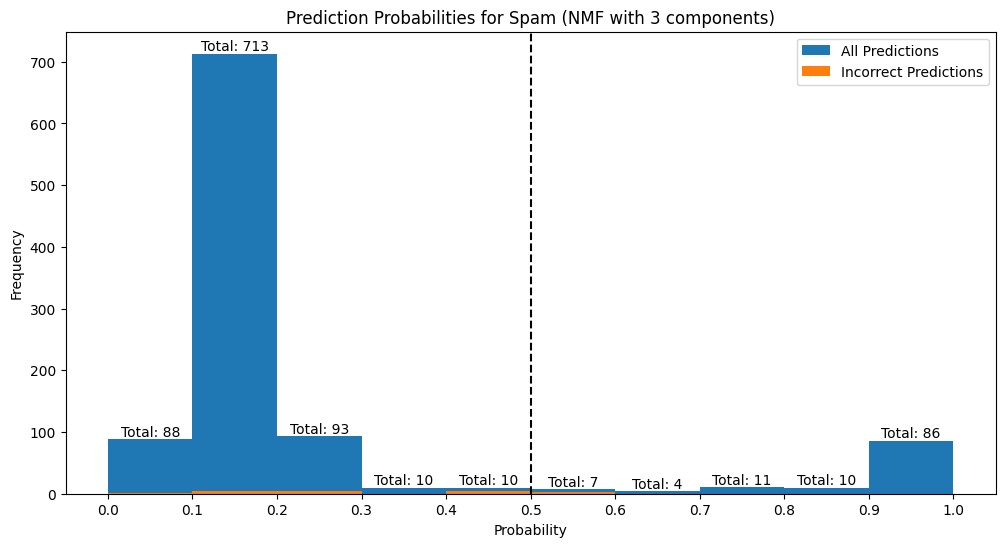

Text  \
3989  (Bank of Granite issues Strong-Buy) EXPLOSIVE ...   
2963  Do you ever notice that when you're driving, a...   
3979                                 ringtoneking 84484   
68    Did you hear about the new \Divorce Barbie\"? ...   
5427  Santa Calling! Would your little ones like a c...   
1879  U have a secret admirer who is looking 2 make ...   
1216  You have 1 new voicemail. Please call 08719181...   
2429  Guess who am I?This is the first time I create...   
1044  We know someone who you know that fancies you....   
5540  ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...   
5466  http//tms. widelive.com/index. wml?id=820554ad...   
2861  Adult 18 Content Your video will be with you s...   
5381         You have 1 new message. Call 0207-083-6089   
1171  Got what it takes 2 take part in the WRC Rally...   
3862  Oh my god! I've found your number again! I'm s...   
4457  Die... I accidentally deleted e msg i suppose ...   
3949  I got to video tape pple type in message lor. ...   

                                          ProcessedText  y_test  y_prob  \
3989  ( bank granite issue strong - buy ) explosive ...    True   False   
2963   notice drive , go slow idiot drive fast maniac ?    True   False   
3979                                         ringtoneke    True   False   
68     hear new \divorce barbie\ " ? come ken stuff ! "    True   False   
5427  santa calling ! little one like santa xmas eve...    True   False   
1879  secret admirer look contact - find r*reveal th...    True   False   
1216                                  new voicemail . .    True   False   
2429  guess i?this time create web page www.asjesus....    True   False   
1044            know know fancy . find . pobox , lshb p    True   False   
5540  asked mobile chatlines inclu free mins . india...    True   False   
5466  http//tms . widelive.com/index . wml?id=ada&fi...    True   False   
2861                        adult content video shortly    True   False   
5381                                  new message . - -    True   False   
1171  get take wrc rally oz ? lucozade energy ! text...    True   False   
3862  oh god ! find number ! glad , text xafter msgs...    True   False   
4457  die ... accidentally delete e msg suppose e si...   False    True   
3949  get video tape pple type message lor . free wa...   False    True   

      y_pred_proba (Spam)  
3989             0.091452  
2963             0.115632  
3979             0.141769  
68               0.156976  
5427             0.188289  
1879             0.205980  
1216             0.208863  
2429             0.229988  
1044             0.257466  
5540             0.296303  
5466             0.402745  
2861             0.402745  
5381             0.402745  
1171             0.430225  
3862             0.484914  
4457             0.508608  
3949             0.521290

In [52]:
# Plot prediction probability frequencies and display misclassified instances
plot_pred_probas(nmf_mod, f'Prediction Probabilities for Spam (NMF with {n_components} components)')
misclassified_preds(nmf_mod)

### Evaluation of NMF + LogReg Model (3 components)

|Method|Components|F1|Precision|Recall|AUC|Fit Time|
|--------|--------|--------|-------|--------|--------|--------|
|Baseline|N/A|0.928571|0.966942|0.89313|0.988969|0.02 sec|
|SVD|150|0.921875|0.944|0.900763|0.983606|0.19 sec|
|NMF|3|0.931727|0.983051|0.885496|0.976201|0.51 sec|

NMF only has 2 False Positives resulting in a higher precision, although has one more False Negative compared to TruncatedSVD. The NMF model also takes a bit longer to train.

The 2 False Positives had prediction probabilities under 0.6 which is close to the threshold, so if we want higher precision we could have just increased the threshold. Alternatively, we could mark instances with probabilities between 0.4 and 0.6 as possible spam.

We can also see a 3D visualization of the test data transformed with NMF. We notice that most of the misclassification are close to the Ham-Spam boundary of Topic 3. The data is mostly linearly separable. Logistic regression, as a linear technique, can take advantage of this, but as the same time will have trouble with points near the boundary. We may either want to try a more flexible classification method, or try a non-linear dimensionality reduction technique that can result in more separated boundaries between classes. We will attempt the latter using UMAP.

## Dimensionality Reduction with UMAP (Uniform Manifold Approximation and Projection)

Unlike SVD and NMF, UMAP is a **non-linear** dimensionality reduction technique. It aims to preserve both local and global structure. In other words, it tries to keep points close to each other in high-dimensional space close together in lower dimensional space, and retain some meaningful poisitioning and distances between separate clusters of points.

Compared to SVD, UMAP is able to preserve local structure well while SVD often loses this structure. On the other hand, SVD is better at preserving global structure due to choosing axes along the directions of variance.

UMAP takes the assumption that the data is uniformly distributed on a *curved* **Riemannian manifold** (from which it gets its name), as opposed to SVD which assumes the data lies in *flat* Euclidean space. Put simply, a Riemannian manifold is a generalization of Euclidean space allowing curved surfaces. Thus, the UMAP algorithm is a non-linear technique that tries to unravel the manifold into a lower-dimensional space, allowing for more flexible compared to linear techniques like SVD.

#### UMAP Parameters
The downside with UMAP is that it's heavily dependant on the hyperparameters chosen and can take longer than the matrix factorization techniques, especially on larger datasets. In particular, the most important parameters are:
* *n_components*: like with the previous techniques, this indicates the number of dimensions in the reduced space
* *n_neighbors*: the number of nearest neighbors to consider when learning the manifold structure of the data. This parameter controls the balance between local and global structure in the data. Lower values focus on local structure, while higher values prioritize broader structure in the data
* *min_dist*: the minimum distance allowed between points in the low dimensional representation. It controls how tightly points are packed together. High values spread the points out, preserving the broader sturcture better, while low values result in tighter clumps of points which useful for clustering.
* *metric*: the distance function used to measure the similarity between points. By default, UMAP uses the euclidean distance. However, for our text data, the angle-based cosine metric would likely work better.

After grid search, I actually found the correlation metric provided somewhat better results than the cosine metric, at the cost of taking longer to compute. The best number of components seemed to be between 15-25 components. Since the difference in components was negligible, I chose to have 15 components.

With the best set of parameters I was able to find, the training and cross validation F1 scores were 0.96903	and 0.864203 respectively. Clearly, this approach is worse than the previous approaches. There is an overfitting problem, which is no surprise since UMAP allows for more flexibility and thus runs the risk of not being able to generalize on unseen data as well. In any case, we'll analyze the results using this method.

In [53]:
# Grid search for UMAP + LogReg model

start_time = time.time()

cv_3_splits = StratifiedKFold(n_splits=3)

param_grid = {
    'umap__n_components': [15],
    'umap__n_neighbors': [8],
    'umap__min_dist': [0.2],
    'logreg__C': [1.0]
}

pipeline = Pipeline([
    ('umap', umap.UMAP(n_components=n_components, metric='correlation')),
    ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=2))
])
gridsearch = GridSearchCV(pipeline, param_grid, scoring='f1', cv=cv_3_splits, n_jobs=-1, verbose=1, return_train_score=True)
gridsearch.fit(X_train_vec, y_train)

# Display best parameters for each n_components
display(grid_search_results(gridsearch.cv_results_))

print(f"Runtime: {round(time.time() - start_time, 2)} seconds")

Fitting 3 folds for each of 1 candidates, totalling 3 fits


logreg__C  umap__min_dist  umap__n_components  umap__n_neighbors  \
0        1.0             0.2                  15                  8   

   mean_train_score  mean_test_score  
0          0.973452         0.862757

Runtime: 162.06 seconds


In [54]:
# Fit UMAP + LogReg Model
n_components = 15

umap_mod = Pipeline([
    ('umap', umap.UMAP(n_components=n_components, n_neighbors=8, min_dist=0.2, metric='correlation', random_state=2)),
    ('logreg', LogisticRegression(C=1.0, max_iter=1000, class_weight='balanced', random_state=2))
])

start_time = time.time()
umap_mod.fit(X_train_vec, y_train)
train_time = round(time.time() - start_time, 2)

print(f"Training Time: {train_time} seconds")

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Training Time: 40.24 seconds


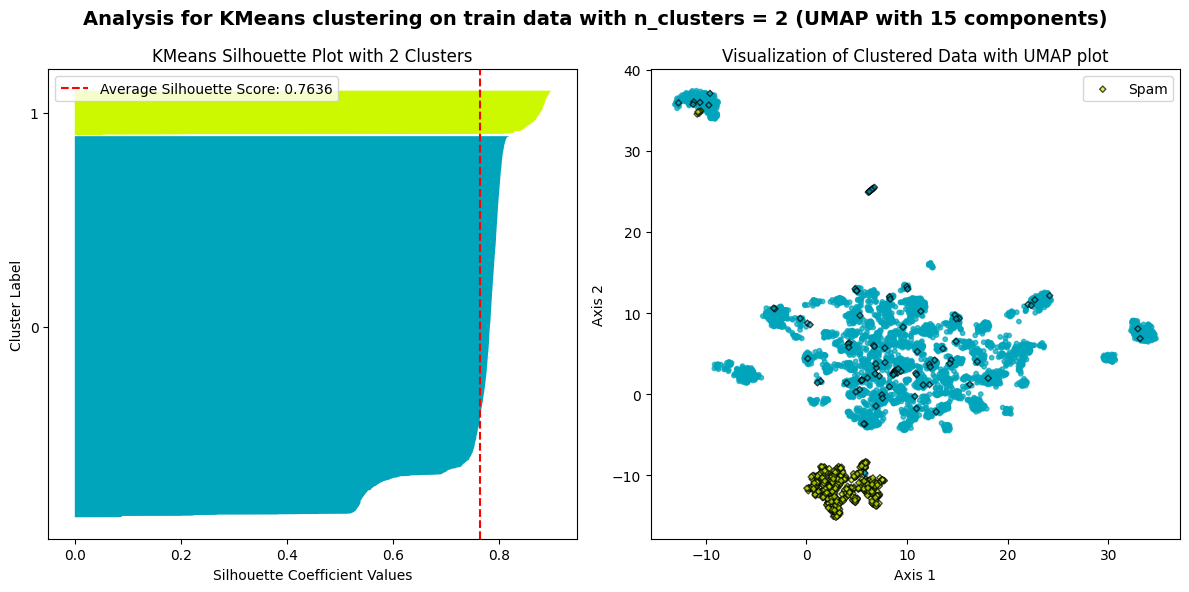

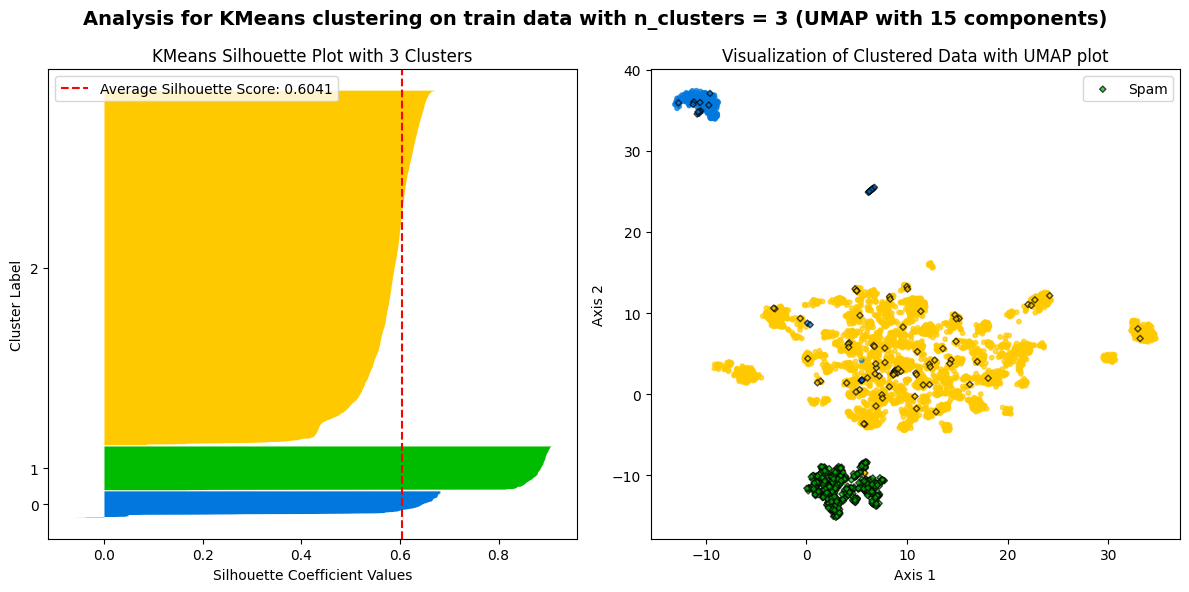

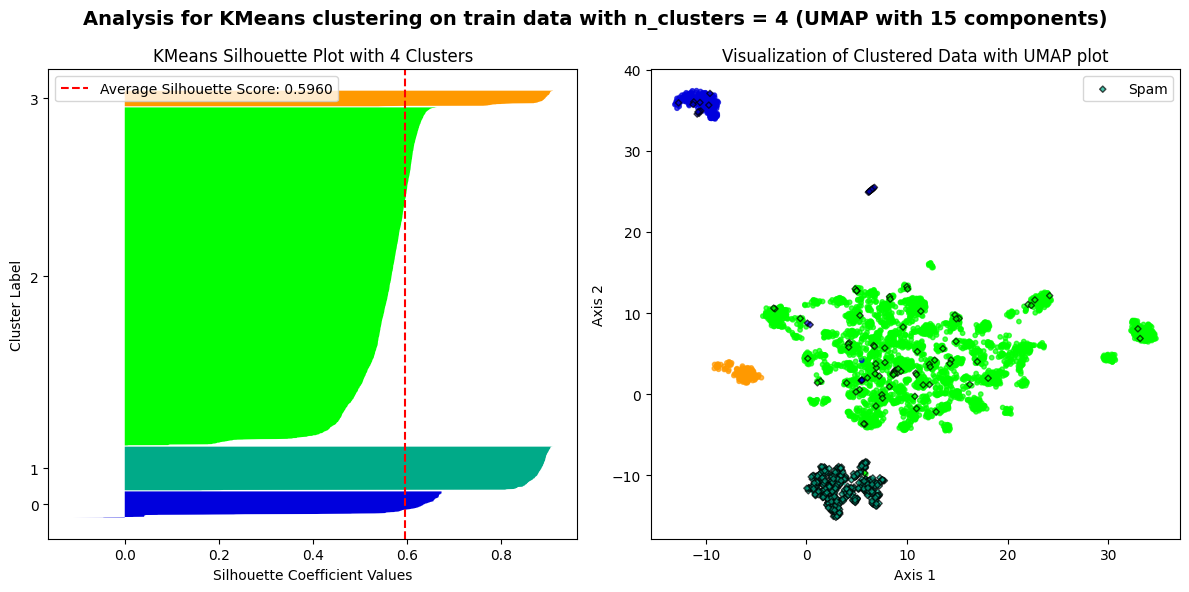

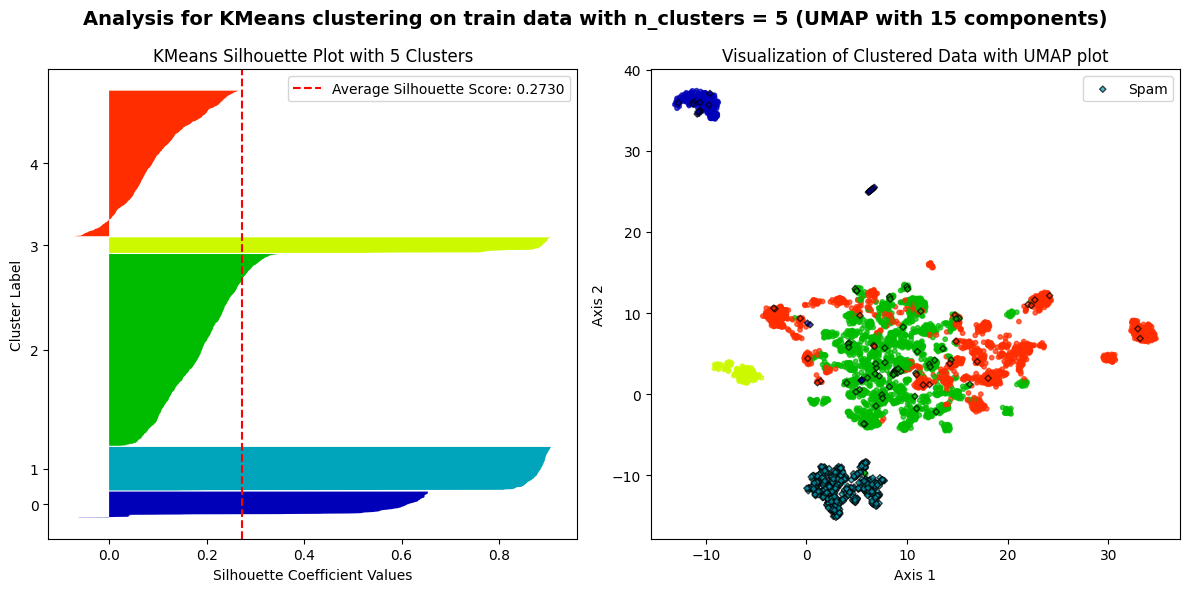

In [55]:
# Analysis for UMAP model with Kmeans n_clusters in range(2, 6)
X_train_umap = umap_mod.named_steps['umap'].transform(X_train_vec)
cluster_analysis(X_train_umap, f"UMAP with {n_components} components", umap_n_d=(100, 0.99))

### Analysis of Clusters

For 2D visualizations, I used UMAP a second time to bring the reduced 15-dimensional further down to 2 dimensions.

The silhoette scores are higher than those of NMF up to 4 clusters. With 2 clusters, we see that one of the clusters captures a majority of the Spam instances. Compared to SVD and NMF, UMAP seems to have clearer separations among groups. However, it does seem to still have the issue of not being able to split the largest cluster well. There are also a number of Spam messages that seemed to have been put further from the majority Spam cluster and closer to Ham messages.

We see three small clusters on the left of the 2D plots, and K-means does generalize recognize these clusters. However, with 5 clusters, we see that the top left group of points have been clustered together with one side of the largest group. While having 5 clusters significantly brings down the average silhoette score, the other clusters are for the most part unchanged, so we'll look at examples from each of these 5 clusters.

In [56]:
# Print 10 examples closest to the centroids of each of 5 clusters
cluster_examples(X_train_umap, n_clusters=5, n_examples=10)

Cluster 0
Ham: s ... mokka player :)
Ham: bluray player
Ham: small dose tablet fever
Ham: k .. k:)where you?how perform ?
Ham: hmmm:)how player select ?
Ham: size elephant tablet & shove um ass ! !
Ham: , , fever , vomitin .
Ham: desperate armand
Ham: k.i did't you.:)k:)where ?
Ham: k.k.how business ?

Cluster 1
Spam: account credit free text messages . activate , txt word : credit : t&cs www..biz
Spam: win nokia i . win free auction . nokia . hg / suite/lands row / wjhl +
Spam: win nokia i . win free auction . nokia . hg / suite/lands row / wjhl +
Spam: urgent ! win week free membership å£, prize jackpot ! txt word : claim : t&c www.dbuk.net lccltd pobox ldnwarw
Spam: sms auction - brand new nokia auction today ! auction free join & ! txt nokia ! hg / suite/lands row / wjhl
Spam: win å£ shopping spree week start . play text store . skilgme . tscs winawk ! age å£.perweeksub .
Spam: sms auction - brand new nokia auction today ! auction free join & ! txt nokia !
Spam: win nokia plus free

As expected, Cluster 1 is centered on Spam messages. The Cluster 3 examples all contain "lt;#&gt" (emojis?). Cluster 0 is less interpretable, but this cluster seems to generally contain shorter messages (although other clusters can also contain short messages).

While the largest group was split between Clusters 2 and 4, it's difficult to make out a difference between the two sets of examples.

In [57]:
# Print kmeans test predictions
X_test_umap = umap_mod.named_steps['umap'].transform(X_test_vec)
kmeans_predictions(X_train_umap, X_test_umap)

Test Cluster Predictions:
label    Ham  Spam
cluster           
0         39     5
1          5    98
2        444    19
3         39     0
4        374     9


After assigning clusters to the test data, we see that it's able to recognize a "Spam" cluster better than with TruncatedSVD. It does worse compared to NMF, although NMF needed two clusters for Spam to separate most of them from the majority Ham clusters.

Training Time: 40.24 seconds
              F1  Precision    Recall       AUC
Scores  0.863071   0.945455  0.793893  0.909244


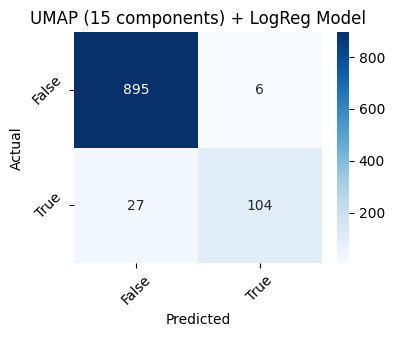

In [58]:
# Evaluate UMAP model on test set
y_pred = umap_mod.predict(X_test_vec)

print(f"Training Time: {train_time} seconds")
evaluate_predictions(umap_mod, X_test_vec, y_test, f"UMAP (15 components) + LogReg Model")

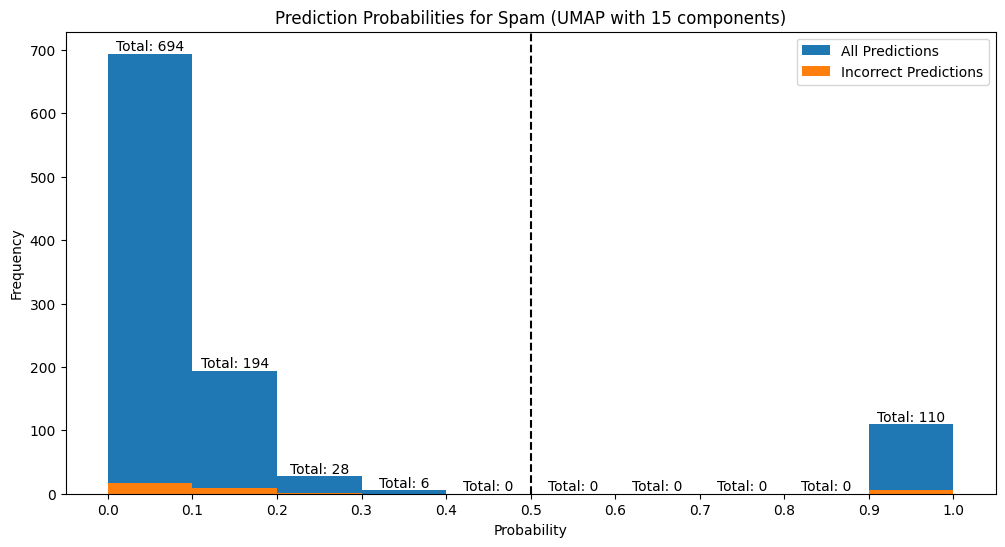

In [59]:
# Plot prediction probability frequencies
plot_pred_probas(umap_mod, f'Prediction Probabilities for Spam (UMAP with {n_components} components)')

### Evaluation of UMAP + LogReg Model (15 components)

|Method|Components|F1|Precision|Recall|AUC|Fit Time|
|--------|--------|--------|-------|--------|--------|--------|
|Baseline|N/A|0.928571|0.966942|0.89313|0.988969|0.02 sec|
|SVD|150|0.921875|0.944|0.900763|0.983606|0.19 sec|
|NMF|3|0.931727|0.983051|0.885496|0.976201|0.51 sec|
|UMAP|15|0.863071|0.945455|0.793893|0.909244|57.51 sec|

The UMAP model is clearly the worst approach for this problem. While in terms of Precision it is comparable to SVD, it performs significantly worse in recall with a recall score of about 79.4%. The UMAP algorithm also take much longer and would scale very badly for larger datasets compared to the two matrix factorization techniques.

Interestingly, when we look at the prediction probabilities, the classifier seems to make clearer judgements on the class probabilities compared to the other two. Since UMAP has more flexible boundaries compared to the linear methods, the separation between classes is more clear, although at the cost of making more mistakes. Like mentioned previously, UMAP seems to overfitting on training data. For this particular dataset a linear method would probably be the preferable option.

## Summary of Model Evaluations and Comparisons

In [60]:
# Get test predictions and prediction probabilities for each model

labels = ['Baseline', 'TruncatedSVD (150 components)', 'NMF (3 components)', 'UMAP (15 components)']
y_preds = []
y_probs = []
scores = []

for mod in [logreg_mod, svd_mod_150, nmf_mod, umap_mod]:
    y_preds.append(mod.predict(X_test_vec))
    y_probs.append(mod.predict_proba(X_test_vec)[:, 1])

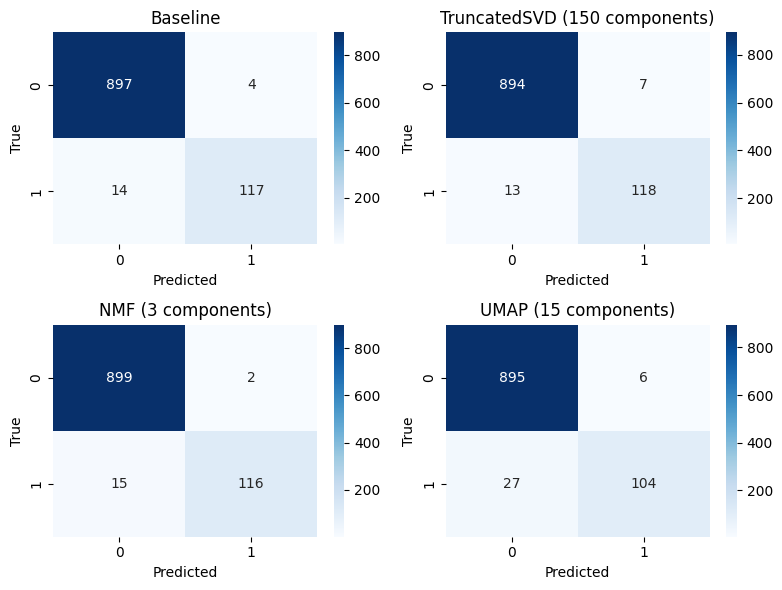

In [61]:
# Display heatmaps of the confusion matrix for each classifier
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()
for y_pred, title, ax in zip(y_preds, labels, axes):
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)
plt.tight_layout()
plt.show()

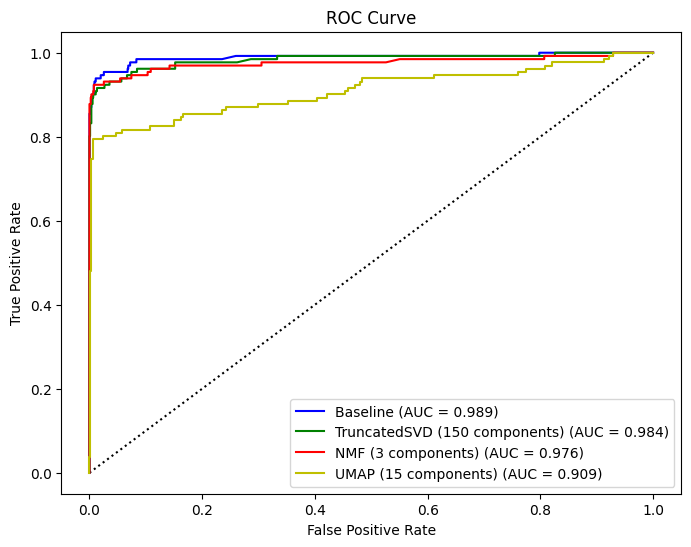

In [62]:
# Plot ROC curves
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k:')
colors = ['b', 'g', 'r', 'y']

for y_prob, label, color in zip(y_probs, labels, colors):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label=f"{label} (AUC = {roc_auc:.3f})")
        
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

|Method|Components|F1|Precision|Recall|AUC|Fit Time|
|--------|--------|--------|-------|--------|--------|--------|
|Baseline|N/A|0.928571|0.966942|0.89313|0.988969|0.02 sec|
|SVD|150|0.921875|0.944|0.900763|0.983606|0.19 sec|
|NMF|3|0.931727|0.983051|0.885496|0.976201|0.51 sec|
|UMAP|15|0.863071|0.945455|0.793893|0.909244|57.51 sec|

The matrix factorization techniques TruncatedSVD and NMF seem to give results comparable to the baseline model, while the non-linear UMAP method does significantly worse in terms of recall.

For classification with logistic regression, the baseline model seems sufficient. It has the highest AUC score, and reducing dimensionality doesn't seem to yield much improvement in detecting Spam instances. However, the NMF model may be considered if it is more important to avoid misclassification of actual Ham instances (avoid False Positives).

Of the three dimensionality reduction techniques, while TruncatedSVD is the fastest and would scale best with large datasets, it yields less interpretable results compared to NMF and is worse at clustering compared to both NMF and UMAP.

UMAP is able to separate data points more clearly so is good for clustering, but is more prone to overfitting and in this case generalizes more poorly compared to TruncatedSVD and UMAP.

Out of the three dimensionality reduction approaches, NMF provides the most benefits for this specific dataset. In addition to yielding comparable results to the baseline model, we were able to bring the data from a 2562-dimensional space down to just 3 dimensions. NMF was also good for topic modeling, producing latent topics that were quite interpretable. We were able to find one latent topic that clearly corresponded to Spam. It also seemed that we would have been able to raise the number of components by a few more without lowering the ability to identify Spam messages, which could've been used to find more latent topics within the data.

# Discussion and Conclusion

SVD, NMF, and UMAP each have their advantages and disadvantages. For this specific dataset, it seems that NMF was the best choice, both for dimensionality reduction and interpretability through topic modeling.


### Main issues with the current approaches

When looking at the types of misclassifications that the models make, it's clear that there are two main issues with the approaches I took: the presence of unseen words (including uncommon words and typos) and the loss of semantic meaning when representing text data as a bag-of-words model.

How well each of these issues are dealt with heavily depend on the preprocessing step as well as the type of word embedding chosen to represent the data. During preprocessing, I could have taken more care to deal with typos such as separating punctuation from words, and I could have also tried different options to remove or exclude certain types of words.

The choice of embedding could also address these issues. Algorithms like Word2Vec and GloVe can capture semantic meaning unlike bag-of-words models like CountVectorizer or TfidfVectorizer. These embeddings unfortunately still cannot deal with the issue of unknown words, but there are other options of embeddings that can do so such as FastText, an extension of Word2Vec, which can generate vectors for out-of-vocabulary words.

### Other possible solutions for classification

While the main focus of this project was on using unsupervised learning techniques to perform dimensionality reduction rather than on improving the accuracy of the classifier, there were multiple other options besides logistic regression such as the stochastic gradient descent algorithm or support vector machine approach. However, a deep learning approach may be more suitable for NLP problems, such as the use of recurrent neural networks (RNNs).

## Resources

Almeida, T.A., GÃ³mez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011.

Almeida, T. A. (n.d.). SMS Spam Collection v.1. University of Campinas. http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/

Jurafsky, D., & Martin, J. H. (2024). Speech and language processing: An introduction to natural language processing, computational linguistics, and speech recognition with language models (3rd ed., draft). https://web.stanford.edu/~jurafsky/slp3/

McInnes, L., Healy, J., & Melville, J. (n.d.). UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. https://umap-learn.readthedocs.io/en/latest/

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, É. (n.d.). sklearn.decomposition.TruncatedSVD. scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, É. (n.d.). sklearn.decomposition.NMF. scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

